In [1]:
import os
import glob
import tqdm
import neurokit as nk
import numpy as np
import pandas as pd
import sklearn
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import featexp

In [2]:
mpl.rcParams['font.sans-serif'].insert(0, 'SimHei')
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# mpl.rcParams['font.serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['figure.figsize'] = (12, 8)

In [3]:
pd.set_option('max_columns', 10000)

In [4]:
data_root = '~/code/python/left5/ecg/ecg_pytorch/data'
train_root = os.path.join(data_root, 'hf_round1_train/train')

train_label_path = os.path.join(data_root, 'hf_round1_label.txt')

In [5]:
label = pd.read_csv(train_label_path, sep="\t", names = list(range(0,12)))#读入每个病例的异常label，因为所有的异常列表都是不对等的，最长的异常个数可能是9个，但是多挖了几个坑，好放下最后会处理掉的
label.columns = ['id','age','gender','f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10','f11']#设置列名
arrythmia = pd.read_csv(os.path.join(data_root, 'hf_round1_arrythmia.txt'),header=None,sep="\t")#读入心电异常事件列表
arrythmia.columns = ['ff1']#不在意这个列名，最后都会消失
all_dis = list(arrythmia.ff1.unique())#所有异常名字

In [6]:
dis_df = pd.DataFrame(np.zeros([label.shape[0],55]))#建立异常列表的dataFrame，作出类似label——encoder 的效果，这样就能完成label的完整建立了
dis_df.columns = all_dis#将异常列表作为列名
new_data = pd.concat([label,dis_df],axis =1)
for i in tqdm(range (new_data.shape[0])):
    dises = list(label.iloc[i,3:11].unique())
    dises.remove(dises[-1])
    for d in dises:
        new_data.loc[i,d]=1

100%|██████████| 24106/24106 [00:22<00:00, 1083.24it/s]


In [7]:
# new_data.head()

In [8]:
new_cols = [col for col in new_data.columns if col not in ['f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10','f11']]#最后过滤掉不需要的列new_data= new_data[new_cols]
new_data= new_data[new_cols]
new_data.head()

,id,age,gender,窦性心律,T波改变,窦性心动过缓,ST段改变,正常ECG,左心室高电压,ST-T改变,窦性心动过速,临界ECG,QRS低电压,房性早搏,电轴左偏,电轴右偏,心房颤动,异常ECG,室性早搏,完全性右束支传导阻滞,窦性心律不齐,左心室肥大,右束支传导阻滞,一度房室传导阻滞,快心室率,不完全性右束支传导阻滞,非特异性T波异常,QT间期延长,左前分支传导阻滞,非特异性ST段异常,差异性传导,非特异性ST段与T波异常,起搏心律,短PR间期,下壁异常Q波,快室率心房颤动,逆钟向转位,室内差异性传导,早期复极化,二联律,室上性早搏,顺钟向转位,复极化异常,未下传的房性早搏,肺心病型,慢心室率,短串房性心动过速,非特异性室内传导延迟,右心房扩大,左束支传导阻滞,前间壁R波递增不良,右心室肥大,房室传导延缓,双分支传导阻滞,非特异性室内传导阻滞,肺型P波,完全性左束支传导阻滞,融合波
0,2.txt,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.txt,40.0,FEMALE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.txt,54.0,FEMALE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.txt,25.0,FEMALE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.txt,37.0,FEMALE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_train_cases = glob.glob('/home/left/code/python/left5/xd/ecg_pytorch/data/hf_round1_train/train/*.txt')#读取所有的文件列表
all_test_cases  = glob.glob('/home/left/code/python/left5/xd/ecg_pytorch/data/hf_round1_testA/testA/*.txt')

In [10]:
def load_data(case):#定义更多参数，具体参考官方说明
    df = pd.read_csv(case,sep=" ")
    df['III'] = df['II']-df['I']
    df['aVR']=-(df['II']+df['I'])/2
    df['aVL']=(df['I']-df['II'])/2
    df['aVF']=(df['II']-df['I'])/2
    return df 
def process1(train_df):
    df = {}
    for col in train_df.columns:
        df[col+'_max'] = train_df[col].max()
        df[col+'_min'] = train_df[col].min()
        df[col+'_mean'] = train_df[col].mean()
        df[col+'_std'] = train_df[col].std()
        df[col+'_ptp'] = train_df[col].max()- train_df[col].min()
    df = pd.DataFrame(df,index=[0])
    return df

In [11]:
#也可以写成一个包，直接调用，我这懒就先这样设定，把数据读入后进行聚合，一个样本得到一行数据
# all_train = pd.DataFrame()
# for sample in tqdm(all_train_cases):
#     demo = load_data(sample)
#     agg_data = process1(demo)#得到聚合数据
#     agg_data['id'] = sample.rsplit('/', 1)[-1]
#     all_train = pd.concat([all_train,agg_data],axis = 0)

# all_test = pd.DataFrame()
# for sample in tqdm(all_test_cases):
#     demo = load_data(sample)
#     agg_data = process1(demo)#得到聚合数据
#     agg_data['id'] = sample.rsplit('/', 1)[-1]
#     all_test = pd.concat([all_test,agg_data],axis = 0)

In [12]:
# pd.to_pickle(all_train, '/home/left/code/python/left5/xd/ecg_pytorch/data/all_train.pkl')
# pd.to_pickle(all_test, '/home/left/code/python/left5/xd/ecg_pytorch/data/all_test.pkl')

In [14]:
all_train = pd.read_pickle('/home/left/code/python/left5/ecg/ecg_pytorch/data/all_train.pkl')
all_test = pd.read_pickle('/home/left/code/python/left5/ecg/ecg_pytorch/data/all_test.pkl')

In [15]:
all_train.head()

,I_max,I_min,I_mean,I_std,I_ptp,II_max,II_min,II_mean,II_std,II_ptp,V1_max,V1_min,V1_mean,V1_std,V1_ptp,V2_max,V2_min,V2_mean,V2_std,V2_ptp,V3_max,V3_min,V3_mean,V3_std,V3_ptp,V4_max,V4_min,V4_mean,V4_std,V4_ptp,V5_max,V5_min,V5_mean,V5_std,V5_ptp,V6_max,V6_min,V6_mean,V6_std,V6_ptp,III_max,III_min,III_mean,III_std,III_ptp,aVR_max,aVR_min,aVR_mean,aVR_std,aVR_ptp,aVL_max,aVL_min,aVL_mean,aVL_std,aVL_ptp,aVF_max,aVF_min,aVF_mean,aVF_std,aVF_ptp,id
0,145,-47,0.7376,22.135120,192,310,-122,0.7826,52.383839,432,192,-320,2.5236,48.421425,512,239,-179,4.0872,66.113413,418,596,-123,4.5702,93.114155,719,616,-107,3.4608,89.408244,723,483,-105,2.7374,67.735217,588,395,-98,2.3708,54.647684,493,199,-120,0.0450,38.075595,319,62.0,-220.0,-0.7601,35.420013,282.0,60.0,-99.5,-0.0225,19.037797,159.5,99.5,-60.0,0.0225,19.037797,159.5,41215.txt
0,96,-31,0.8470,18.566037,127,368,-58,2.1772,54.166996,426,104,-241,-0.0368,39.234196,345,269,-338,2.2764,65.673122,607,381,-95,4.3748,79.152815,476,693,-114,5.5358,119.423835,807,664,-107,4.2106,107.365518,771,561,-108,2.6280,91.849358,669,311,-56,1.3302,40.154153,367,35.0,-226.5,-1.5121,35.160938,261.5,28.0,-155.5,-0.6651,20.077077,183.5,155.5,-28.0,0.6651,20.077077,183.5,44246.txt
0,86,-38,-0.1980,14.529412,124,151,-50,-0.0366,26.856126,201,80,-121,0.3052,22.309433,201,168,-277,0.2640,53.077107,445,220,-257,-0.1964,53.219683,477,316,-191,0.5002,51.883743,507,274,-119,-0.1620,42.018573,393,199,-59,0.2726,31.854859,258,113,-29,0.1614,15.463026,142,38.0,-103.5,0.1173,20.159399,141.5,14.5,-56.5,-0.0807,7.731513,71.0,56.5,-14.5,0.0807,7.731513,71.0,29223.txt
0,172,-66,1.4648,23.999382,238,271,-69,1.5998,35.583036,340,131,-151,3.2684,35.091416,282,248,-250,3.6036,72.531518,498,344,-229,5.8746,71.875560,573,497,-164,5.4364,77.583819,661,441,-79,5.0078,61.739035,520,346,-102,-0.0688,48.794949,448,188,-79,0.1350,22.608985,267,51.0,-198.5,-1.5323,28.165047,249.5,39.5,-94.0,-0.0675,11.304493,133.5,94.0,-39.5,0.0675,11.304493,133.5,37744.txt
0,217,-149,-0.0998,41.308633,366,293,-59,-0.4274,42.863842,352,31,-100,-1.1126,17.125378,131,118,-299,-0.2090,48.450428,417,122,-232,-0.4404,36.618042,354,180,-165,-0.1110,32.271755,345,243,-108,0.3178,34.400556,351,264,-59,-0.0072,36.849558,323,300,-99,-0.3276,44.646511,399,78.5,-218.0,0.2636,35.686529,296.5,49.5,-150.0,0.1638,22.323255,199.5,150.0,-49.5,-0.1638,22.323255,199.5,27548.txt


In [16]:
all_train.columns

Index(['I_max', 'I_min', 'I_mean', 'I_std', 'I_ptp', 'II_max', 'II_min',
       'II_mean', 'II_std', 'II_ptp', 'V1_max', 'V1_min', 'V1_mean', 'V1_std',
       'V1_ptp', 'V2_max', 'V2_min', 'V2_mean', 'V2_std', 'V2_ptp', 'V3_max',
       'V3_min', 'V3_mean', 'V3_std', 'V3_ptp', 'V4_max', 'V4_min', 'V4_mean',
       'V4_std', 'V4_ptp', 'V5_max', 'V5_min', 'V5_mean', 'V5_std', 'V5_ptp',
       'V6_max', 'V6_min', 'V6_mean', 'V6_std', 'V6_ptp', 'III_max', 'III_min',
       'III_mean', 'III_std', 'III_ptp', 'aVR_max', 'aVR_min', 'aVR_mean',
       'aVR_std', 'aVR_ptp', 'aVL_max', 'aVL_min', 'aVL_mean', 'aVL_std',
       'aVL_ptp', 'aVF_max', 'aVF_min', 'aVF_mean', 'aVF_std', 'aVF_ptp',
       'id'],
      dtype='object')

In [17]:
#对之前的label数据进行一些整理
gender_map = {'MALE':0,'FEMALE':1}
new_data.gender=new_data.gender.map(gender_map)
new_data.gender.fillna(1,inplace=True)
new_data.age.fillna(-1,inplace=True)

In [18]:
new_data

,id,age,gender,窦性心律,T波改变,窦性心动过缓,ST段改变,正常ECG,左心室高电压,ST-T改变,窦性心动过速,临界ECG,QRS低电压,房性早搏,电轴左偏,电轴右偏,心房颤动,异常ECG,室性早搏,完全性右束支传导阻滞,窦性心律不齐,左心室肥大,右束支传导阻滞,一度房室传导阻滞,快心室率,不完全性右束支传导阻滞,非特异性T波异常,QT间期延长,左前分支传导阻滞,非特异性ST段异常,差异性传导,非特异性ST段与T波异常,起搏心律,短PR间期,下壁异常Q波,快室率心房颤动,逆钟向转位,室内差异性传导,早期复极化,二联律,室上性早搏,顺钟向转位,复极化异常,未下传的房性早搏,肺心病型,慢心室率,短串房性心动过速,非特异性室内传导延迟,右心房扩大,左束支传导阻滞,前间壁R波递增不良,右心室肥大,房室传导延缓,双分支传导阻滞,非特异性室内传导阻滞,肺型P波,完全性左束支传导阻滞,融合波
0,2.txt,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.txt,40.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.txt,54.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.txt,25.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.txt,37.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,16.txt,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,17.txt,68.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,21.txt,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,23.txt,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,24.txt,73.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
all_df = pd.merge(new_data,all_train,on = 'id')
all_df.head()#这样完整的可用于训练的数据就产生了

bins = [-2,0,18,25,35,45,60,120]#可视化时候使用，作为特征也可以使用，年龄分箱操作，看个人习惯
all_df.age = pd.cut(all_df.age,bins) #,labels=[''])

In [20]:
all_df.head()

,id,age,gender,窦性心律,T波改变,窦性心动过缓,ST段改变,正常ECG,左心室高电压,ST-T改变,窦性心动过速,临界ECG,QRS低电压,房性早搏,电轴左偏,电轴右偏,心房颤动,异常ECG,室性早搏,完全性右束支传导阻滞,窦性心律不齐,左心室肥大,右束支传导阻滞,一度房室传导阻滞,快心室率,不完全性右束支传导阻滞,非特异性T波异常,QT间期延长,左前分支传导阻滞,非特异性ST段异常,差异性传导,非特异性ST段与T波异常,起搏心律,短PR间期,下壁异常Q波,快室率心房颤动,逆钟向转位,室内差异性传导,早期复极化,二联律,室上性早搏,顺钟向转位,复极化异常,未下传的房性早搏,肺心病型,慢心室率,短串房性心动过速,非特异性室内传导延迟,右心房扩大,左束支传导阻滞,前间壁R波递增不良,右心室肥大,房室传导延缓,双分支传导阻滞,非特异性室内传导阻滞,肺型P波,完全性左束支传导阻滞,融合波,I_max,I_min,I_mean,I_std,I_ptp,II_max,II_min,II_mean,II_std,II_ptp,V1_max,V1_min,V1_mean,V1_std,V1_ptp,V2_max,V2_min,V2_mean,V2_std,V2_ptp,V3_max,V3_min,V3_mean,V3_std,V3_ptp,V4_max,V4_min,V4_mean,V4_std,V4_ptp,V5_max,V5_min,V5_mean,V5_std,V5_ptp,V6_max,V6_min,V6_mean,V6_std,V6_ptp,III_max,III_min,III_mean,III_std,III_ptp,aVR_max,aVR_min,aVR_mean,aVR_std,aVR_ptp,aVL_max,aVL_min,aVL_mean,aVL_std,aVL_ptp,aVF_max,aVF_min,aVF_mean,aVF_std,aVF_ptp
0,2.txt,"(-2, 0]",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65,-19,-0.1446,10.083433,84,71,-24,-0.2174,11.341581,95,78,-291,-0.2558,46.030361,369,183,-628,-0.1816,96.499433,811,310,-495,0.2868,78.208651,805,315,-330,-0.1856,56.056500,645,218,-143,-0.3784,30.091207,361,138,-30,0.2112,17.035852,168,36,-65,-0.0728,8.824300,101,17.5,-65.5,0.1810,9.781946,83.0,32.5,-18.0,0.0364,4.412150,50.5,18.0,-32.5,-0.0364,4.412150,50.5
1,5.txt,"(35, 45]",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,-46,0.1740,10.116511,90,79,-34,0.4440,12.128326,113,31,-125,-0.2268,20.080827,156,61,-311,-0.5542,49.258546,372,99,-163,-0.3454,28.980332,262,109,-118,-0.4038,20.884980,227,153,-62,0.1734,20.917525,215,145,-29,0.1748,18.852727,174,94,-30,0.2700,12.593253,124,31.0,-37.5,-0.3090,9.223477,68.5,15.0,-47.0,-0.1350,6.296626,62.0,47.0,-15.0,0.1350,6.296626,62.0
2,9.txt,"(45, 60]",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112,-51,-0.0724,23.756381,163,61,-23,0.3482,11.621255,84,37,-123,-0.1756,17.203219,160,70,-116,0.4716,17.718543,186,50,-44,0.4490,9.945933,94,120,-35,0.3370,17.955431,155,139,-31,-0.1254,18.993184,170,126,-24,-0.6120,18.551590,150,52,-71,0.4206,16.923066,123,29.5,-86.5,-0.1379,16.676692,116.0,35.5,-26.0,-0.2103,8.461533,61.5,26.0,-35.5,0.2103,8.461533,61.5
3,12.txt,"(18, 25]",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90,-54,-0.4714,19.831123,144,81,-33,0.4808,14.329225,114,44,-69,0.2738,13.050950,113,77,-95,0.0794,21.331378,172,68,-57,-0.2858,14.549875,125,80,-61,0.1910,16.416102,141,70,-39,0.2208,15.473175,109,77,-39,-0.4966,13.848579,116,52,-53,0.9522,11.627939,105,37.0,-76.0,-0.0047,16.294104,113.0,26.5,-26.0,-0.4761,5.813969,52.5,26.0,-26.5,0.4761,5.813969,52.5
4,14.txt,"(35, 45]",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163,-41,0.1666,22.045799,204,145,-29,0.0174,19.242254,174,32,-68,-0.2588,14.689662,100,45,-56,0.2780,10.269421,101,140,-45,-0.2064,15.658175,185,193,-28,-0.5910,22.692737,221,181,-70,0.3180,27.459543,251,150,-24,0.0142,17.333300,174,30,-36,-0.1492,9.039075,66,34.5,-150.0,-0.0920,20.191943,184.5,18.0,-15.0,0.0746,4.519538,33.0,15.0,-18.0,-0.0746,4.519538,33.0


In [21]:
# plt.figure(figsize=(12,10))
# plt.suptitle(' Distributions', fontsize=22)
total = 10000
def Distribute_df(df,col):
    max_count = 1.2*df[col].value_counts().max()
    plt.subplot(111)
    plot_1 = sns.countplot(x=col, data=df)
    plot_1.set_title("%s Distribution" % col, fontsize=18)
    plot_1.set_xlabel("%s" % col, fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    plot_1.set_ylim(0,max_count)
    for p in plot_1.patches:
        height = p.get_height()
        plot_1.text(p.get_x()+p.get_width()/2., 
                    height,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
    plt.show()


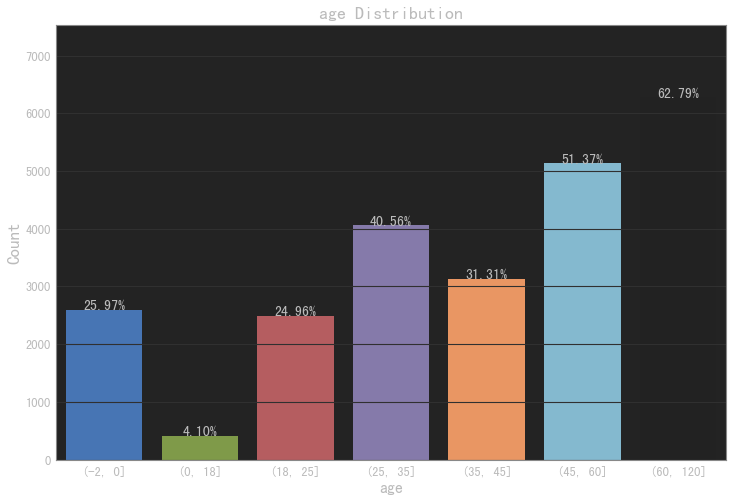

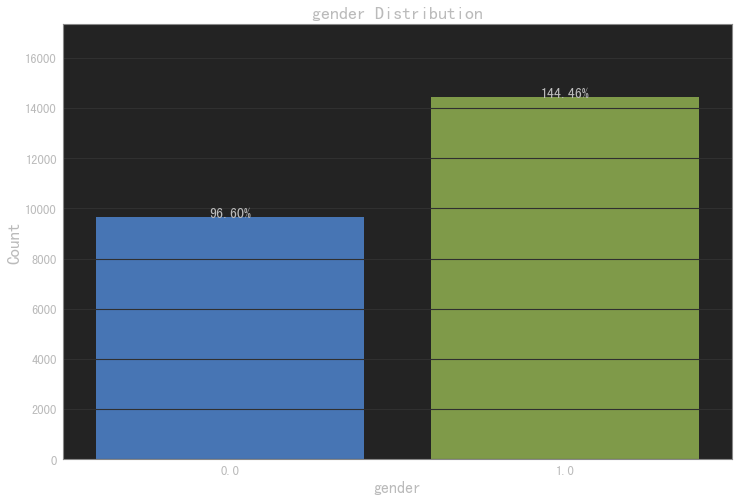

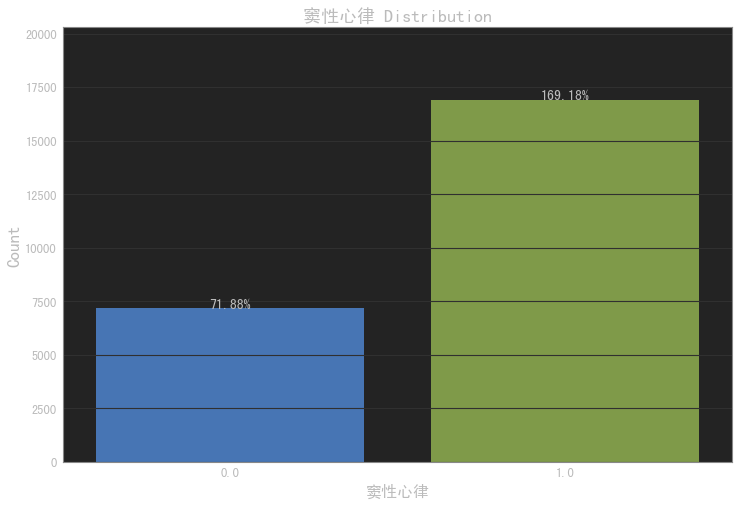

In [22]:
Distribute_df(all_df,'age')
Distribute_df(all_df,'gender')
Distribute_df(all_df,'窦性心律')

In [23]:
#按照不同年龄段区分各心脏异常情况分布
def distribution_by_dis(df,col):
#     plt.figure(figsize=(14,10))
    plt.figure()
    plt.suptitle('   Distributions', fontsize=22)
#     plt.subplot(122)
    g1 = sns.countplot(x='age', hue=col, data=df)
    g1.set_title('age by %s' % col, fontsize=15)
    g1.set_xlabel("age bin", fontsize=15)
    g1.set_ylabel("Count", fontsize=15)
    plt.legend(title=col, loc='best', labels=['No', 'Yes'])

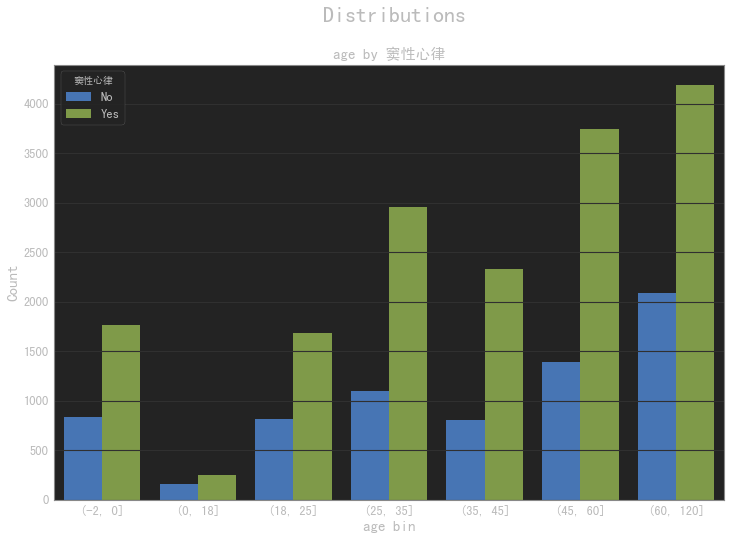

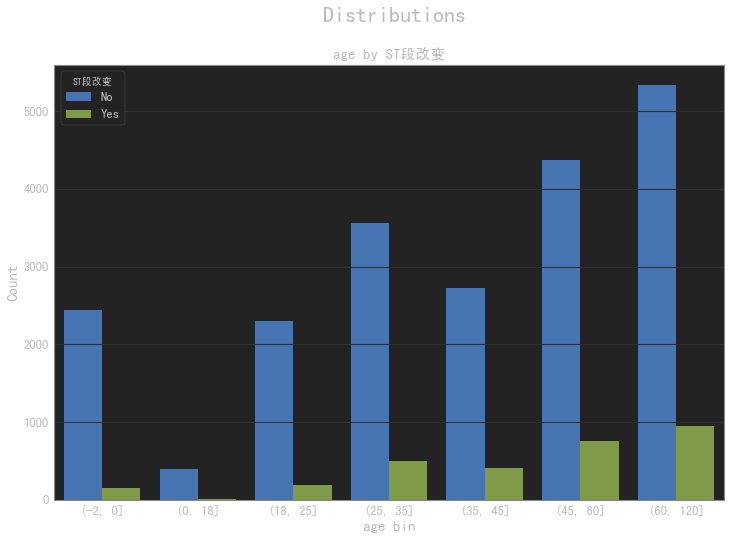

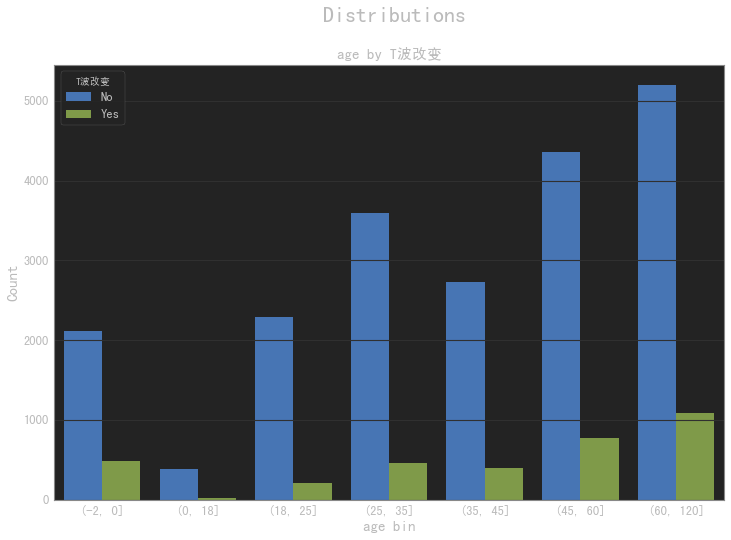

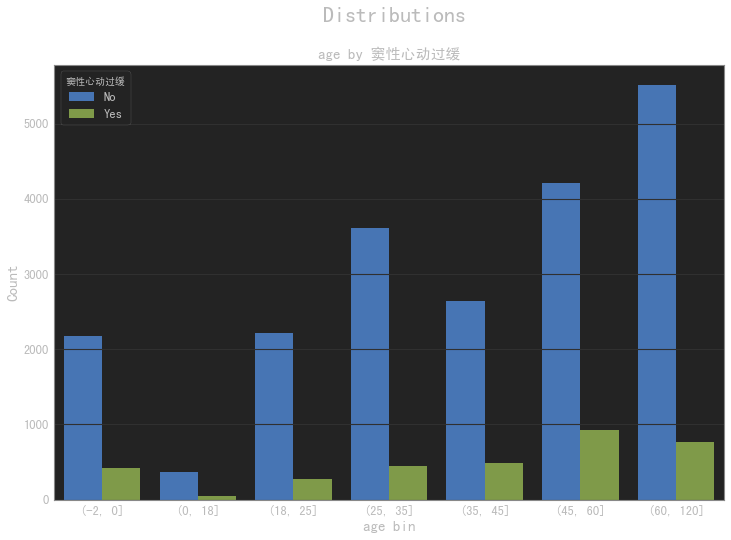

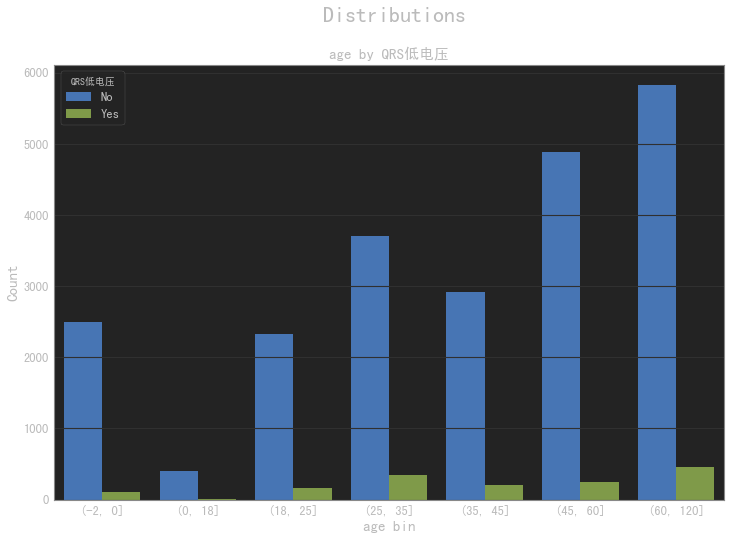

In [24]:
distribution_by_dis(all_df, '窦性心律')
distribution_by_dis(all_df, 'ST段改变')
distribution_by_dis(all_df, 'T波改变')
distribution_by_dis(all_df, '窦性心动过缓')
distribution_by_dis(all_df, 'QRS低电压')

In [25]:
#按照性别，观察各类异常的分布
def distribution_by_gender(df,col):
#     plt.figure(figsize=(12,8))
    plt.figure()
    plt.suptitle(' Distributions', fontsize=22)
#     plt.subplot(122)
    g1 = sns.countplot(x='gender', hue=col, data=df)
    g1.set_title('gener by %s'%col, fontsize = 15)
    g1.set_xlabel("gender", fontsize=15)
    g1.set_ylabel("Count", fontsize=15)
    plt.legend(title=col, loc='best', labels=['No', 'Yes'])


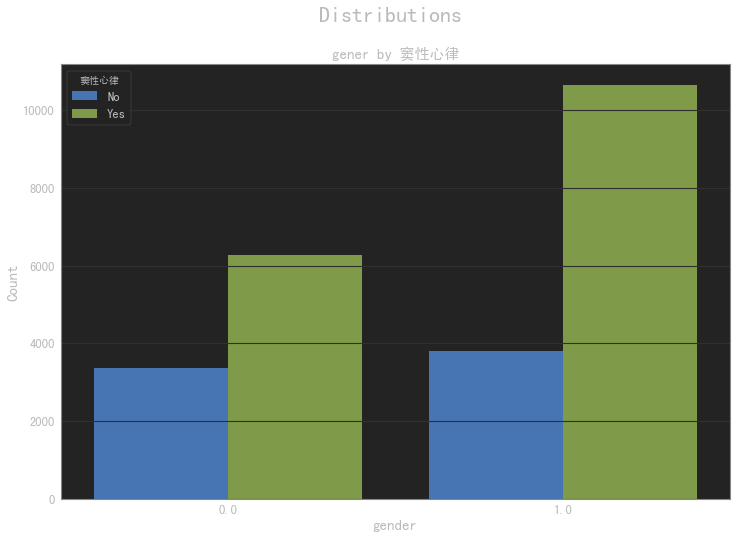

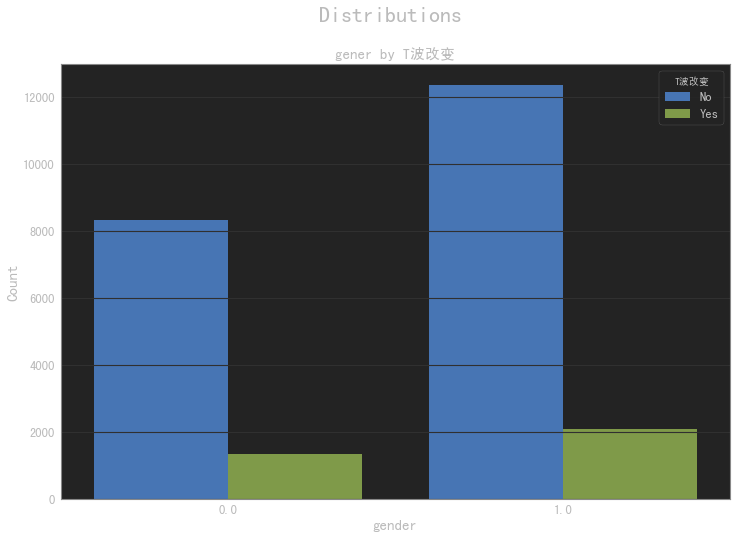

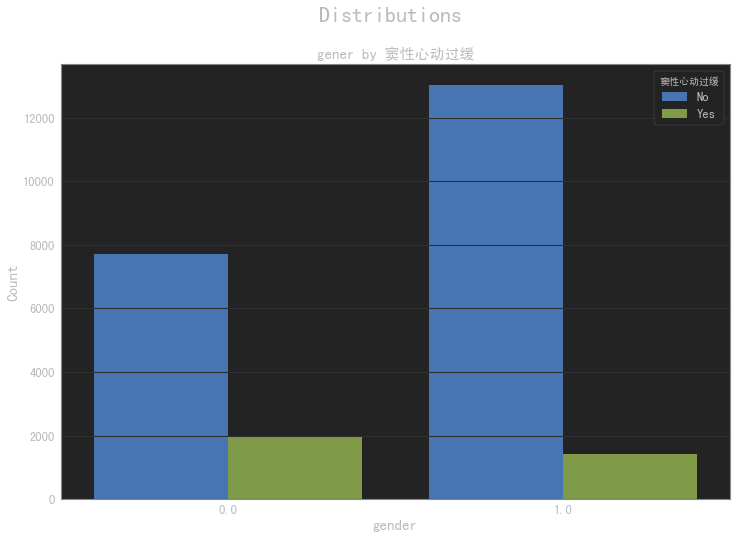

In [26]:
distribution_by_gender(all_df, '窦性心律')
distribution_by_gender(all_df, 'T波改变')
distribution_by_gender(all_df, '窦性心动过缓')

In [27]:
def violin(df, col, col1):
    fig, ax = plt.subplots() # figsize=(10, 10))
    plot = sns.violinplot(x=col, y=col1, data=df, palette=["limegreen", "red"], ax=ax).set_title(col, fontsize=16)
    plt.show()


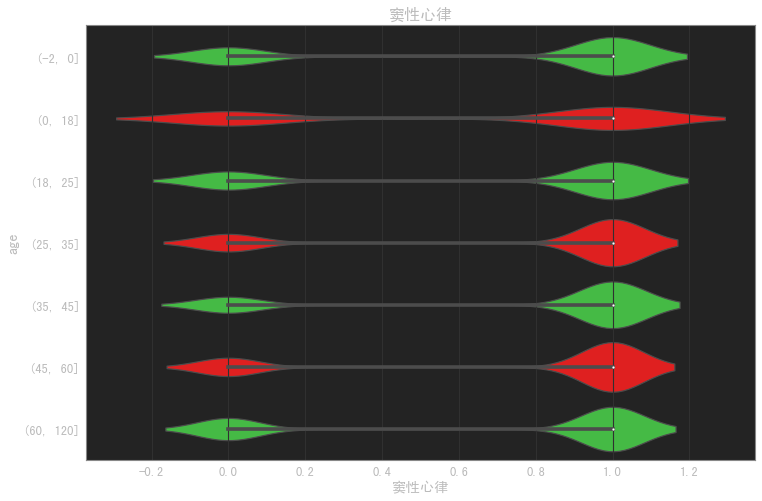

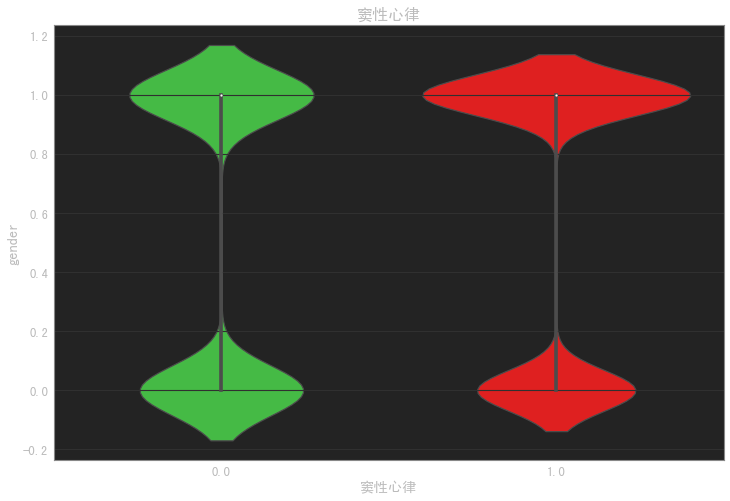

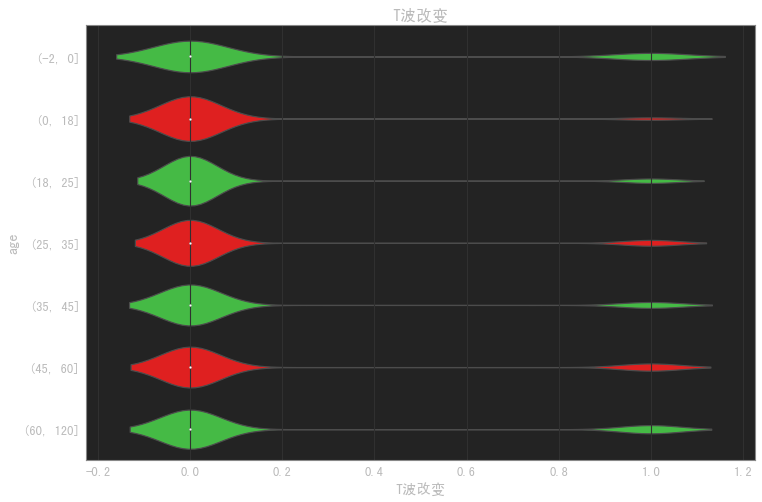

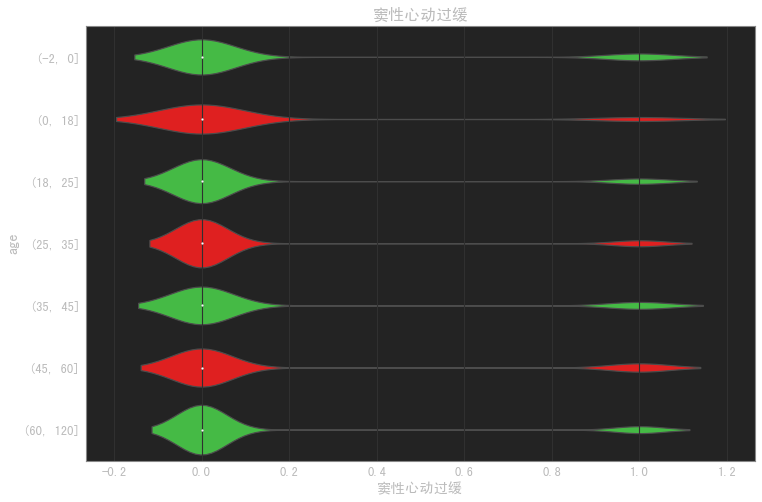

In [28]:
violin(all_df,"窦性心律","age")
violin(all_df,"窦性心律","gender")
violin(all_df,"T波改变","age")
violin(all_df,"窦性心动过缓","age")

In [5]:
df = pd.read_csv(os.path.join(train_root, '2.txt'), sep=' ')

In [6]:
df.columns

Index(['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], dtype='object')

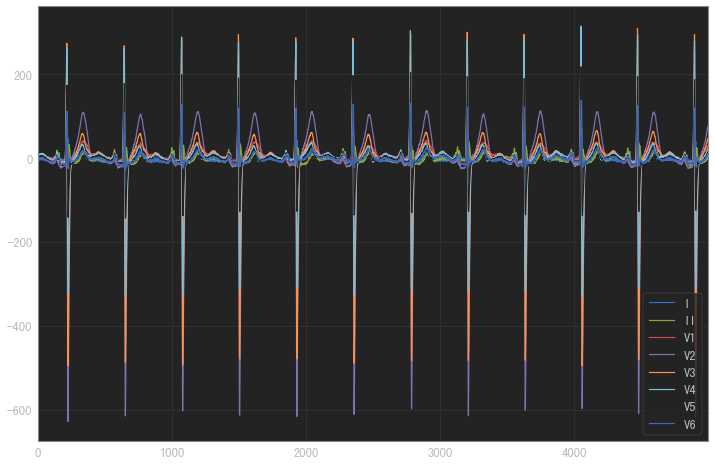

In [7]:
df.plot()

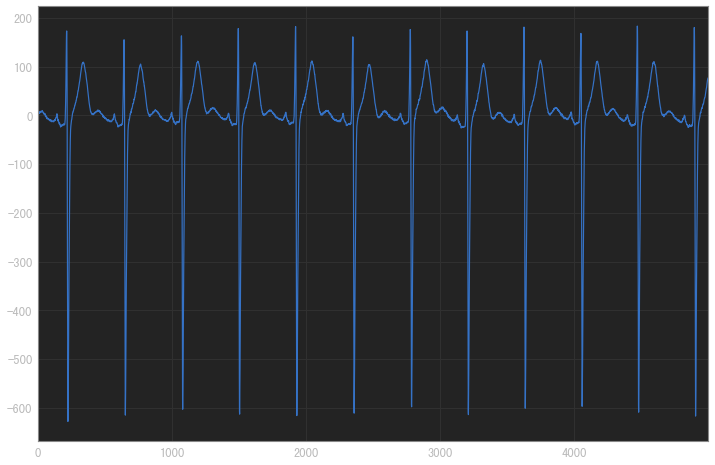

In [8]:
df['V2'].plot()

In [46]:
bio = nk.bio_process(ecg=df['V2'], sampling_rate=500, ecg_hrv_features=['time'])

/home/left/venv36/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/left/venv36/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [47]:
# import warnings

In [48]:
# warnings.warn("deprecated", UserWarning)

In [49]:
bio['df'].columns

Index(['ECG_Raw', 'ECG_Filtered', 'ECG_R_Peaks', 'Heart_Rate', 'ECG_Systole',
       'ECG_Signal_Quality'],
      dtype='object')

In [50]:
bio.keys()

dict_keys(['ECG', 'df'])

In [51]:
bio['ECG'].keys()

dict_keys(['R_Peaks', 'Cardiac_Cycles', 'T_Waves', 'P_Waves', 'Q_Waves', 'S_Waves', 'Q_Waves_Onsets', 'T_Waves_Onsets', 'T_Waves_Ends', 'Probable_Lead', 'Cardiac_Cycles_Signal_Quality', 'Average_Signal_Quality', 'ECG_Signal_Quality', 'HRV'])

In [52]:
bio['ECG']['Cardiac_Cycles'].head()

,0,1,2,3,4,5,6,7,8,9,10
2019-10-17 17:30:03.072520,-3.356980,-3.015220,-3.566854,-2.716855,-3.693745,-3.200084,-2.800720,-2.969877,-2.659875,-3.403812,-3.353631
2019-10-17 17:30:03.074520,-3.394999,-3.131443,-3.441784,-2.820210,-3.779748,-2.934641,-2.769886,-2.743050,-2.669894,-3.201289,-3.242691
2019-10-17 17:30:03.076520,-3.368587,-3.379130,-3.319068,-2.946437,-3.846677,-2.729394,-2.742029,-2.574134,-2.856449,-3.001250,-3.210057
2019-10-17 17:30:03.078520,-3.289712,-3.696815,-3.192076,-3.059184,-3.884178,-2.613368,-2.699211,-2.474739,-3.165054,-2.833258,-3.235424
2019-10-17 17:30:03.080520,-3.171935,-3.993801,-3.042447,-3.117145,-3.870749,-2.585369,-2.612331,-2.424476,-3.499938,-2.707461,-3.263473


In [53]:
bio['df'].head()

,ECG_Raw,ECG_Filtered,ECG_R_Peaks,Heart_Rate,ECG_Systole,ECG_Signal_Quality
0,4,0.169046,NaN,NaN,0,NaN
1,5,0.324743,NaN,NaN,0,NaN
2,4,0.479148,NaN,NaN,0,NaN
3,5,0.630456,NaN,NaN,0,NaN
4,5,0.776110,NaN,NaN,0,NaN


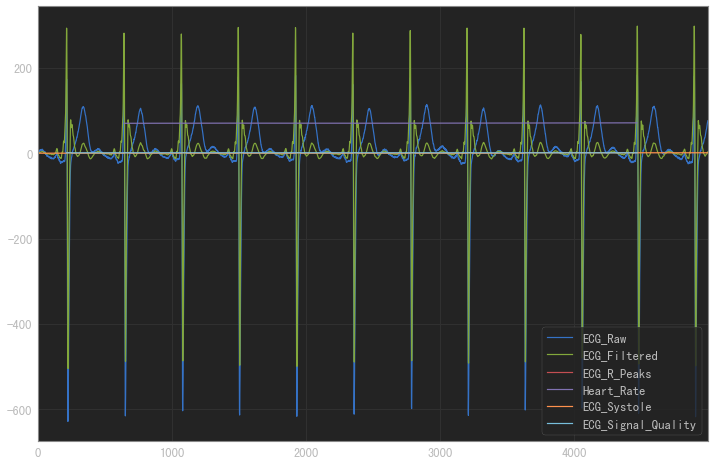

In [56]:
bio['df'].plot()

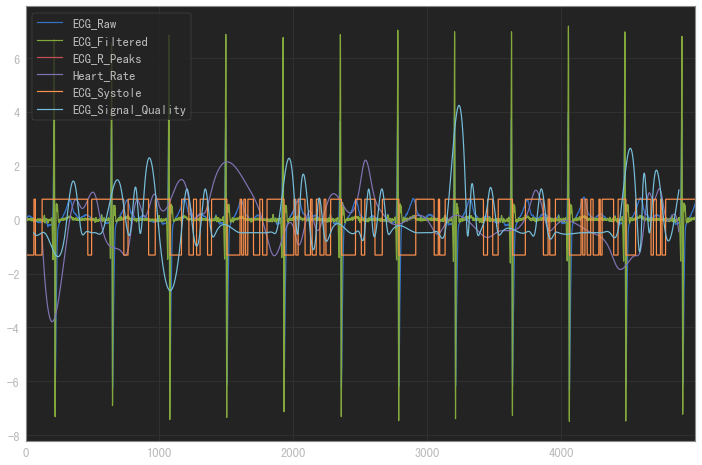

In [64]:
nk.z_score(bio['df']).plot()

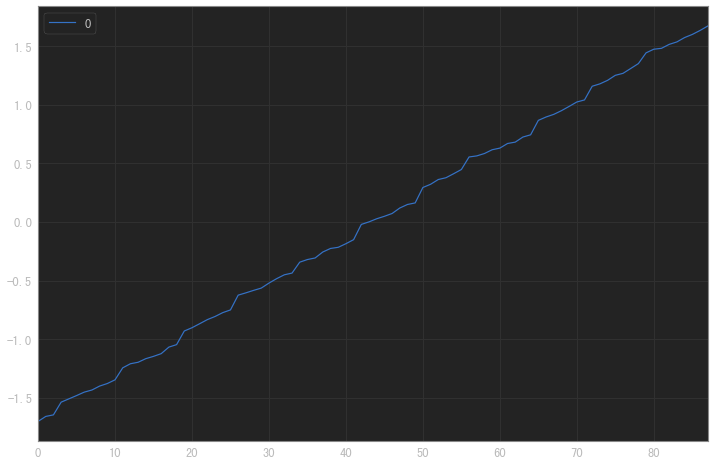

In [65]:
nk.z_score(bio['ECG']['R_Peaks']).plot()

In [66]:
bio['ECG']['Average_Signal_Quality']

0.2523402784304082

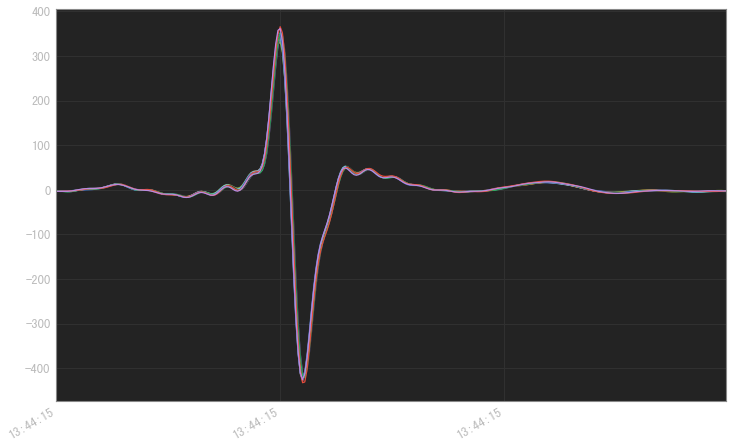

In [79]:
pd.DataFrame(bio['ECG']['Cardiac_Cycles']).plot(legend=False)

In [81]:
bio['ECG']['Cardiac_Cycles']

RangeIndex(start=0, stop=11, step=1)

In [105]:
bio["df"].columns

Index(['ECG_Raw', 'ECG_Filtered', 'ECG_R_Peaks', 'Heart_Rate', 'ECG_Systole',
       'ECG_Signal_Quality', 'ECG_RR_Interval', 'ECG_HRV_ULF', 'ECG_HRV_VLF',
       'ECG_HRV_LF', 'ECG_HRV_HF', 'ECG_HRV_VHF'],
      dtype='object')

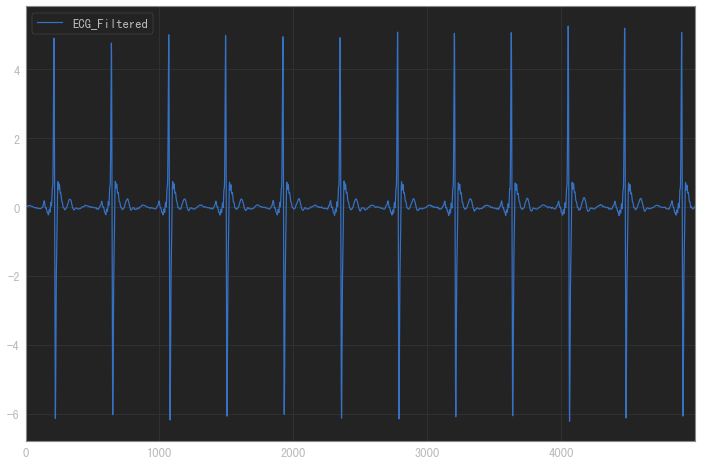

In [107]:
# nk.z_score(bio['df'][['ECG_Filtered', 'RSP_Filtered', 'RSA']]).plot()
nk.z_score(bio['df'][['ECG_Filtered']]).plot()

In [108]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

In [ ]:
# df["Photosensor"]

In [ ]:
# events = nk.find_events(df["Photosensor"], cut="lower")
# events

In [63]:
# os.listdir('~/code/python/left5/ecg/ecg_pytorch/data/hf_round1_train/train')

FileNotFoundError: [Errno 2] No such file or directory: '~/code/python/left5/ecg/ecg_pytorch/data/hf_round1_train/train'

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
root = '/home/left/code/python/left5/ecg/ecg_pytorch/data/hf_round1_train/train'
for f in tqdm_notebook(os.listdir(root)):
    df = pd.read_csv(os.path.join(root, f), sep=' ')
    for col in df.columns:
        try:
            bio = nk.bio_process(ecg=df[col], sampling_rate=500, ecg_hrv_features=None)
        except:
            tqdm.write('%s: %s' % (f, col))

21196.txt: V2
21196.txt: V4
21196.txt: V6
21085.txt: V2
21085.txt: V4
21085.txt: V6
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
3832.txt: V3
30833.txt: I
21481.txt: I
21481.txt: V3
21481.txt: V4
21481.txt: V5
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
7486.txt: V2
16361.txt: V2
16361.txt: V4
16361.txt: V6
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
35005.txt: II
17937.txt: V2
17937.txt: V4
17937.txt: V6
34093.txt: V2
34093.txt: V4
34093.txt: V6
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
32048.txt: V4
NeuroKit Warning: ecg_process(): Sequence too short to compute heart rate.
30475.txt: I
30475.txt: V3
30475.txt: V4
30475.txt: V5
20813.txt: V2

In [23]:
df = pd.read_csv(os.path.join(train_root, '30833.txt'), sep=' ') # 21196.txt

In [24]:
df.columns

Index(['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], dtype='object')

In [ ]:
for col in df.columns[:1]:
    print(col)
    bio = nk.bio_process(ecg=df[col], sampling_rate=500, ecg_hrv_features=['time'])

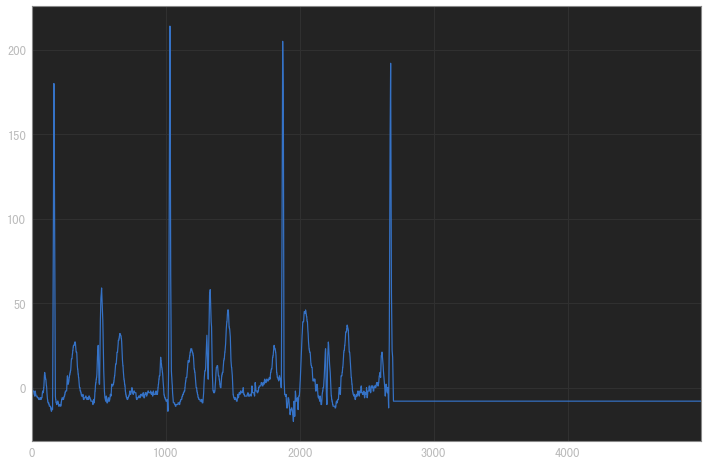

In [26]:
df['I'].plot()

In [7]:
error_fs = '''21196.txt: V2
21196.txt: V4
21196.txt: V6
21085.txt: V2
21085.txt: V4
21085.txt: V6
3832.txt: V3
30833.txt: I
21481.txt: I
21481.txt: V3
21481.txt: V4
21481.txt: V5
7486.txt: V2
16361.txt: V2
16361.txt: V4
16361.txt: V6
35005.txt: II
17937.txt: V2
17937.txt: V4
17937.txt: V6
34093.txt: V2
34093.txt: V4
34093.txt: V6
32048.txt: V4
30475.txt: I
30475.txt: V3
30475.txt: V4
30475.txt: V5
20813.txt: V2
20813.txt: V4
20813.txt: V6
27979.txt: V2
27979.txt: V4
27979.txt: V6
20814.txt: V2
20814.txt: V4
20814.txt: V6
29889.txt: V2
29889.txt: V4
29889.txt: V6
18030.txt: V2
18030.txt: V4
18030.txt: V6
17900.txt: V2
17900.txt: V4
17900.txt: V6
10242.txt: V2
4938.txt: V1
4938.txt: V6
32702.txt: V1
32702.txt: V6
31752.txt: V1
14939.txt: V4'''

In [8]:
error_dict = dict()
for line in error_fs.splitlines():
    f, col = [l.strip() for l in line.split(':')]
    ls = error_dict.get(f, [])
    ls.append(col)
    error_dict[f] = ls

mv 21196.txt ..
mv 21085.txt ..
mv 3832.txt ..
mv 30833.txt ..
mv 21481.txt ..
mv 7486.txt ..
mv 16361.txt ..
mv 35005.txt ..
mv 17937.txt ..
mv 34093.txt ..
mv 32048.txt ..
mv 30475.txt ..
mv 20813.txt ..
mv 27979.txt ..
mv 20814.txt ..
mv 29889.txt ..
mv 18030.txt ..
mv 17900.txt ..
mv 10242.txt ..
mv 4938.txt ..
mv 32702.txt ..
mv 31752.txt ..
mv 14939.txt ..


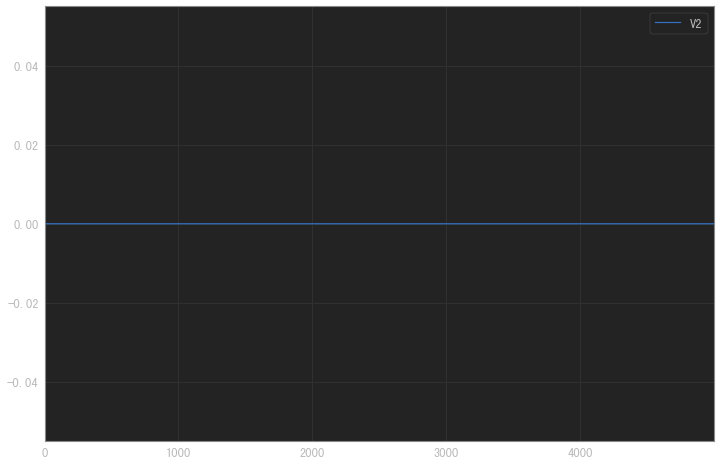

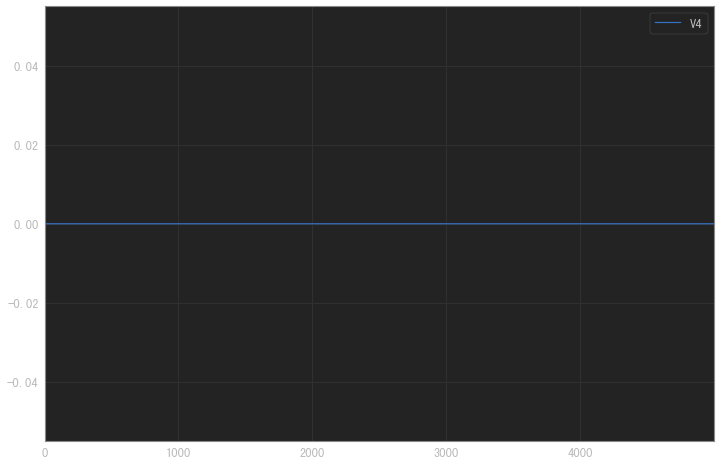

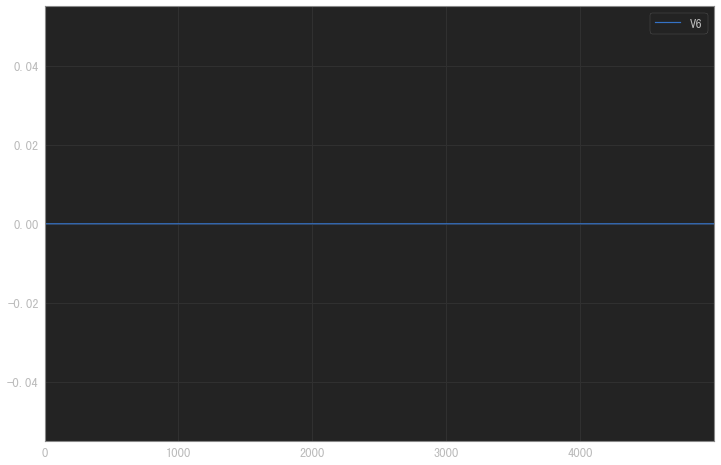

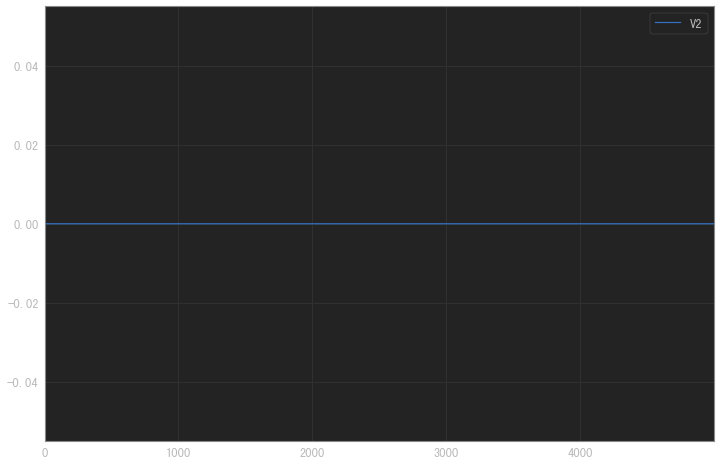

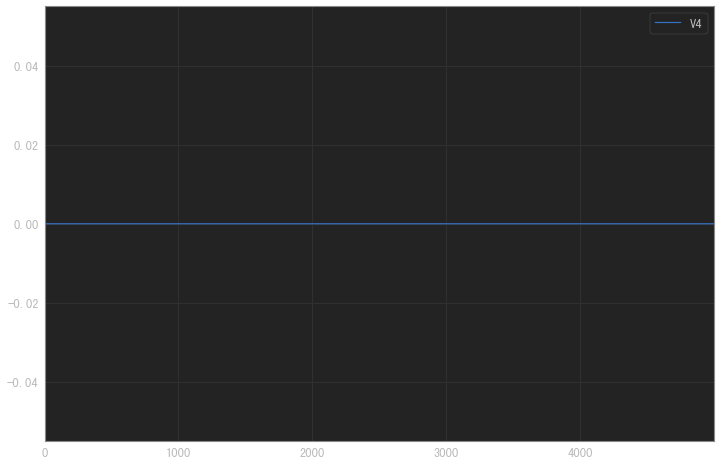

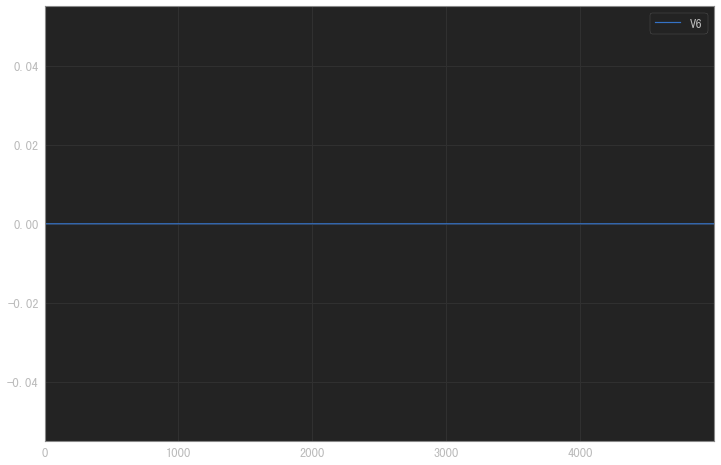

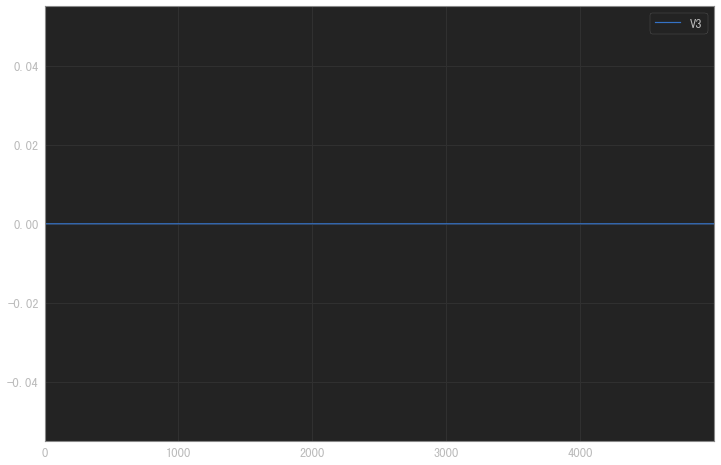

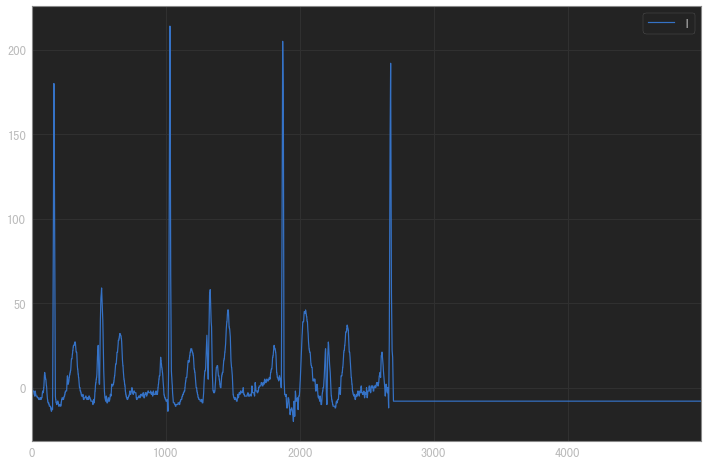

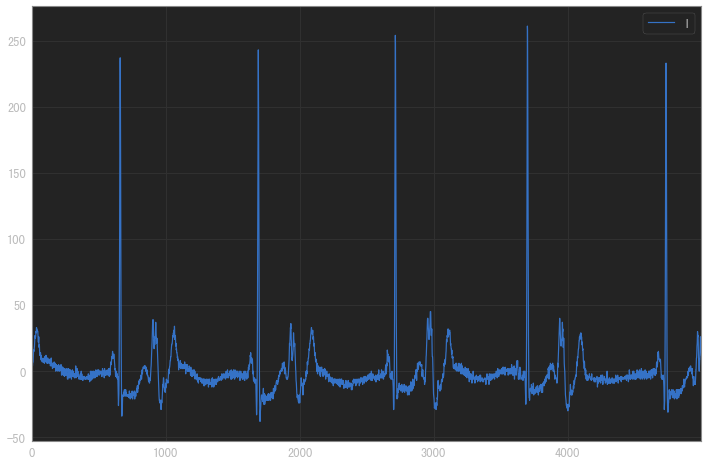

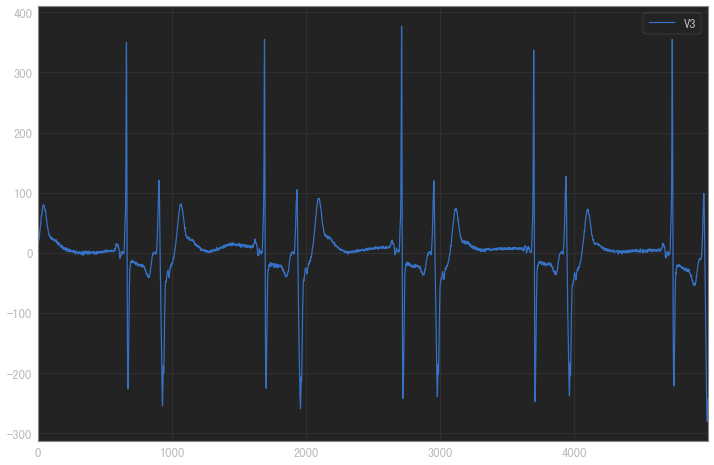

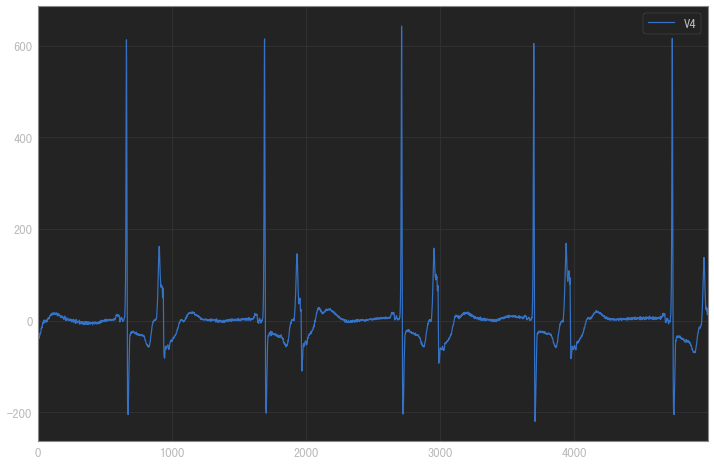

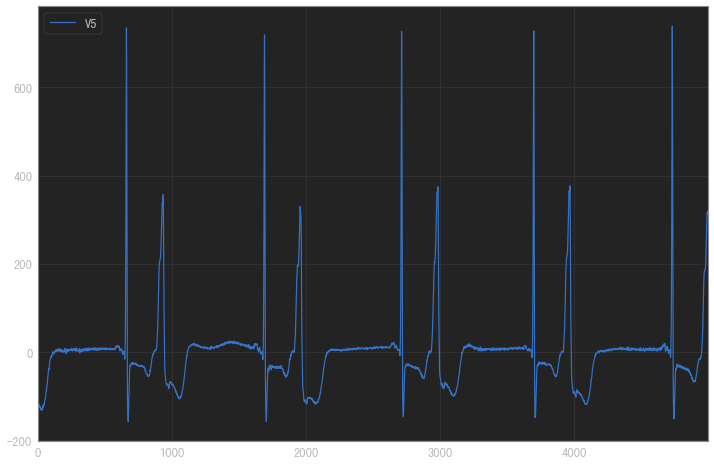

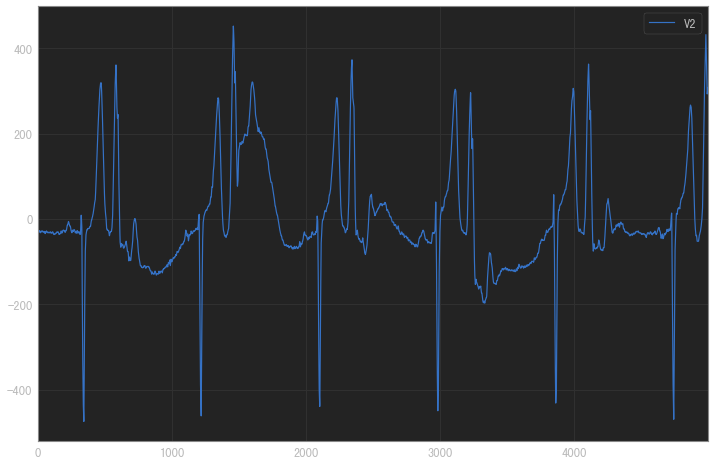

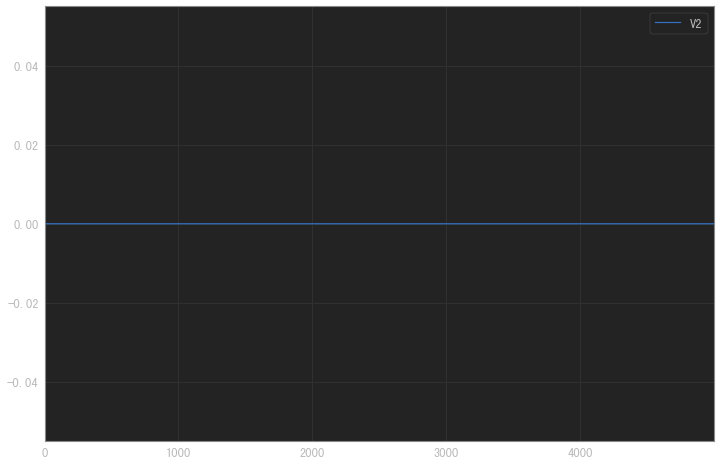

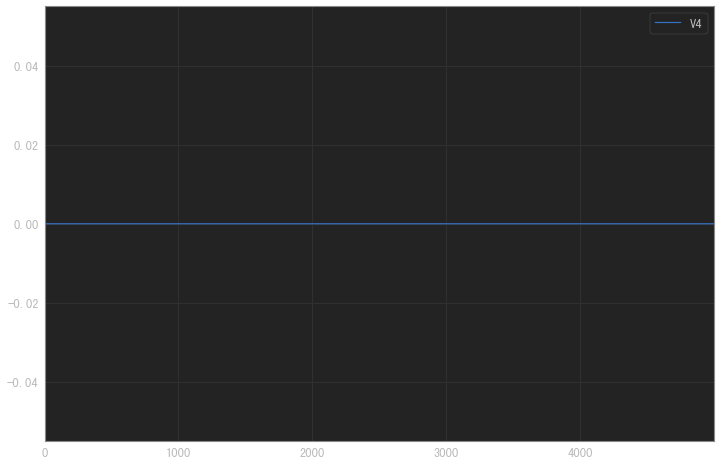

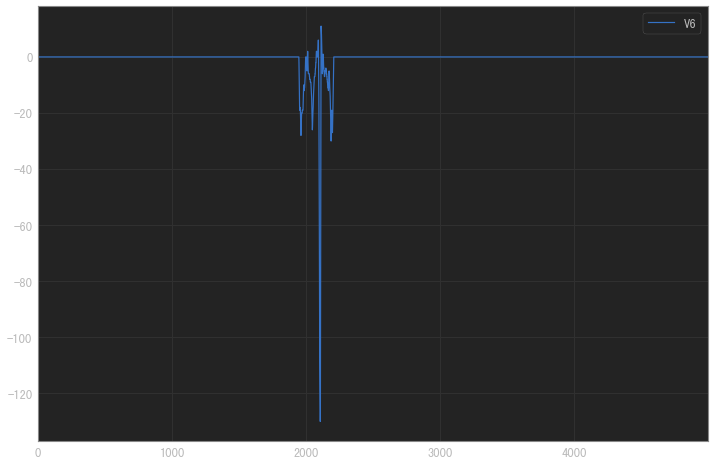

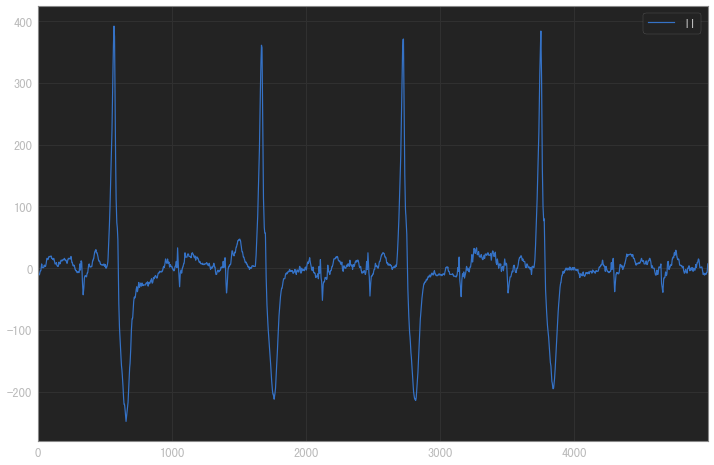

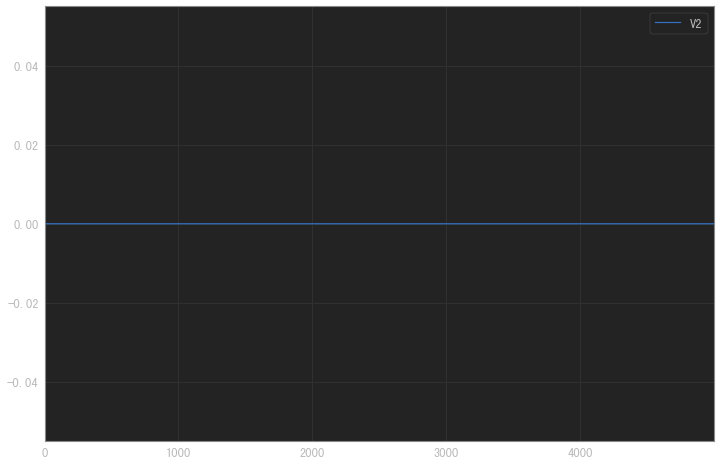

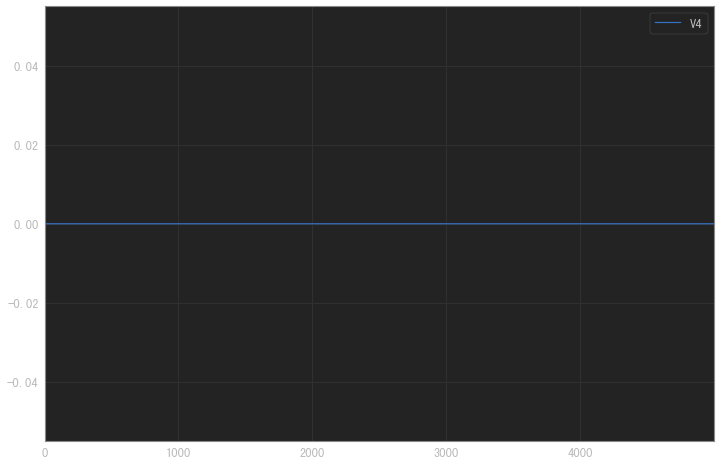

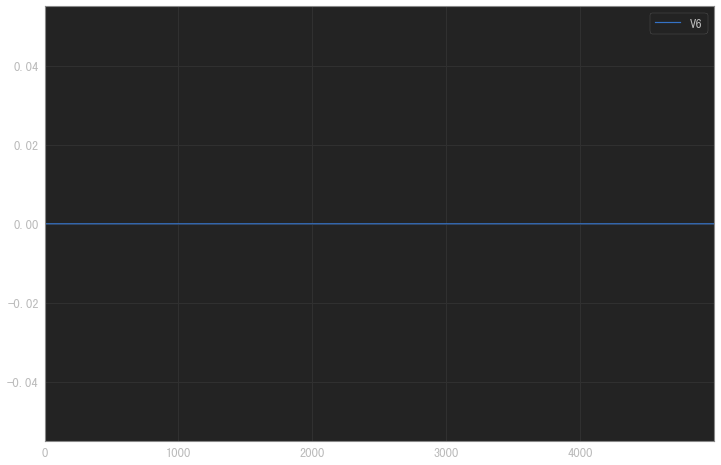

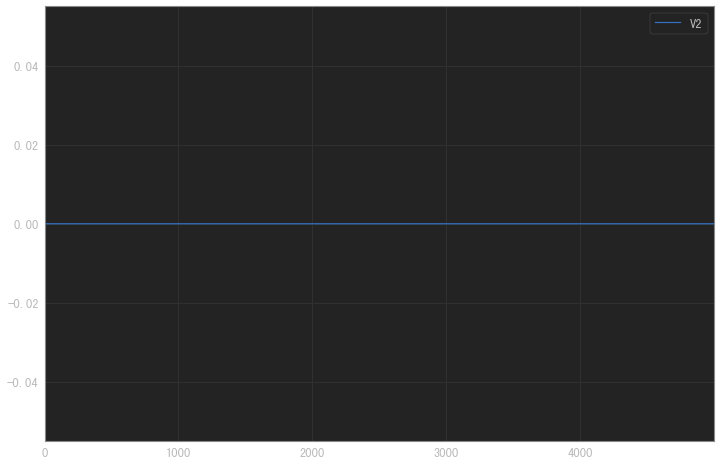

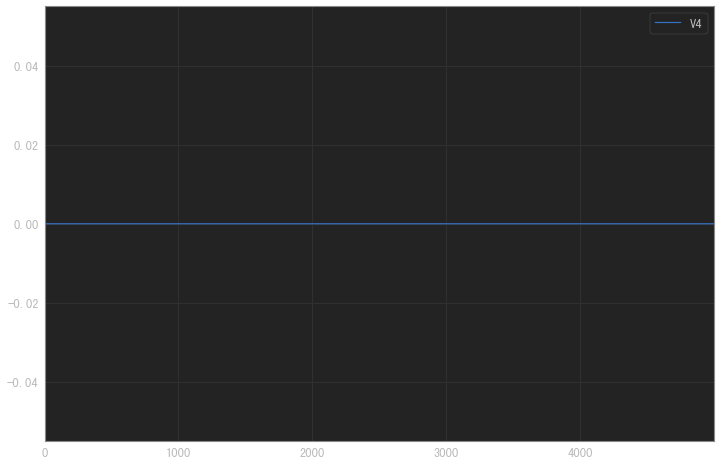

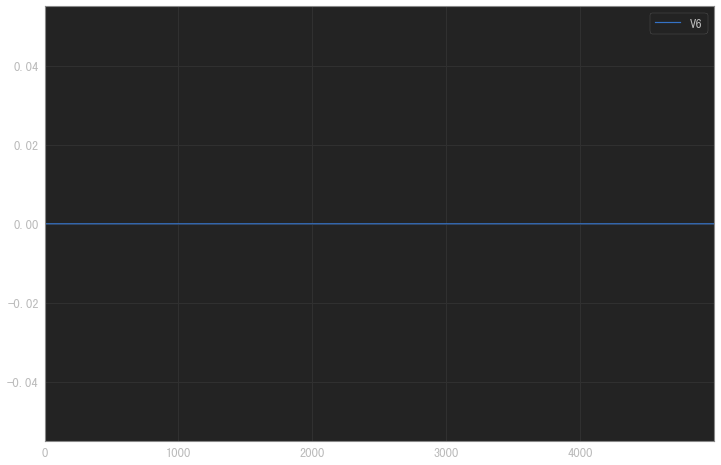

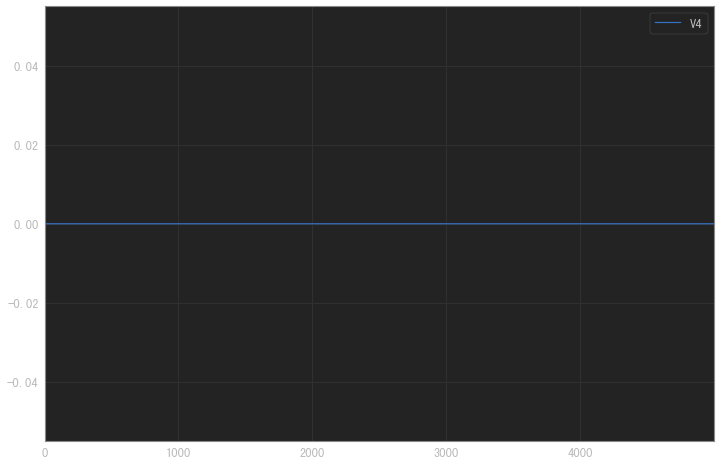

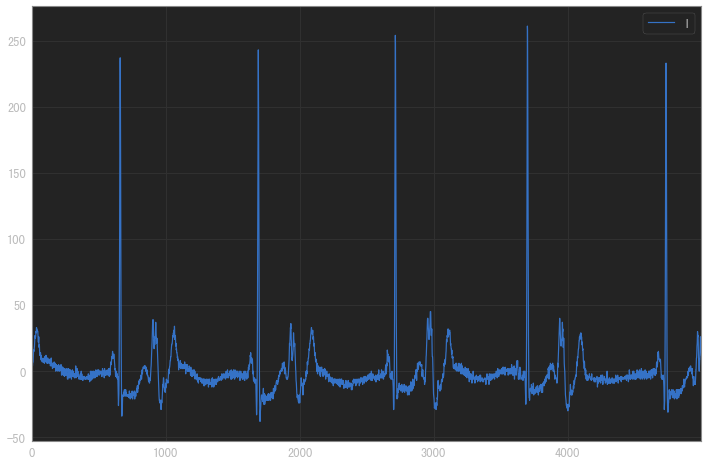

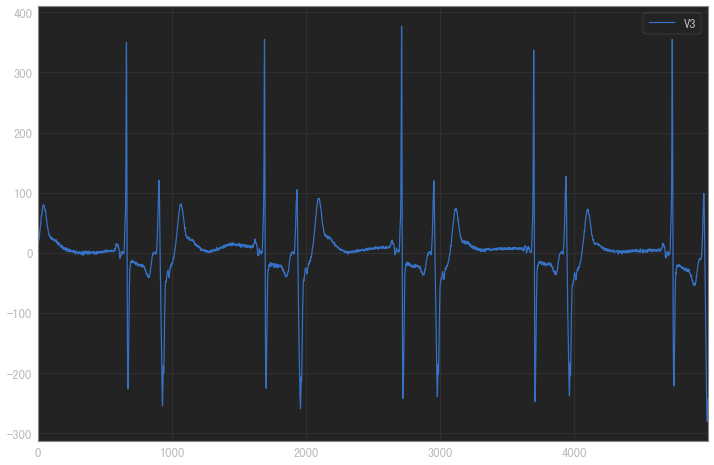

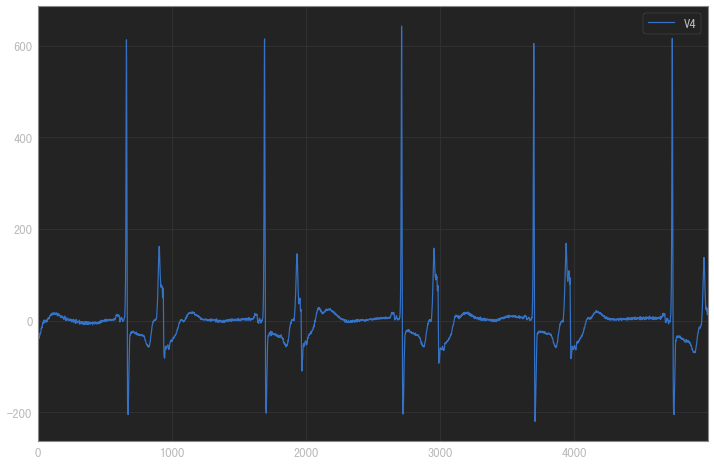

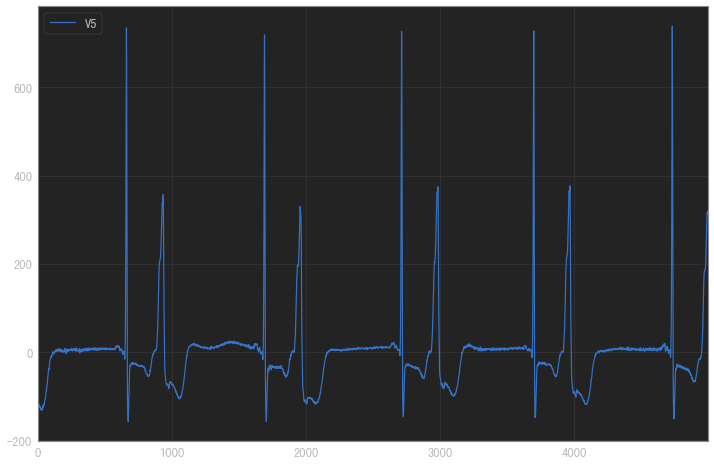

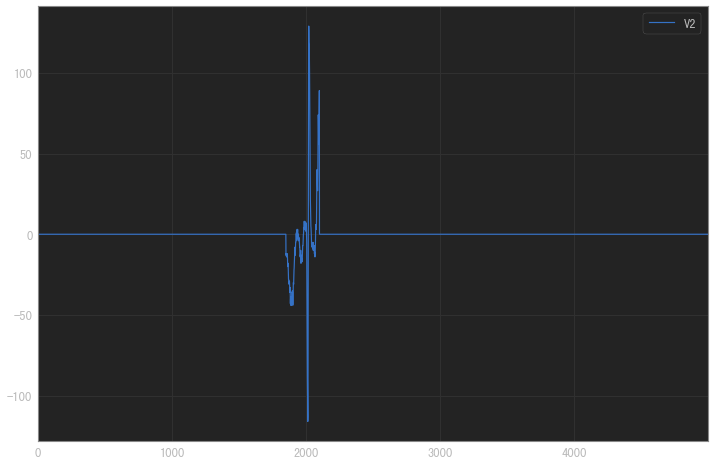

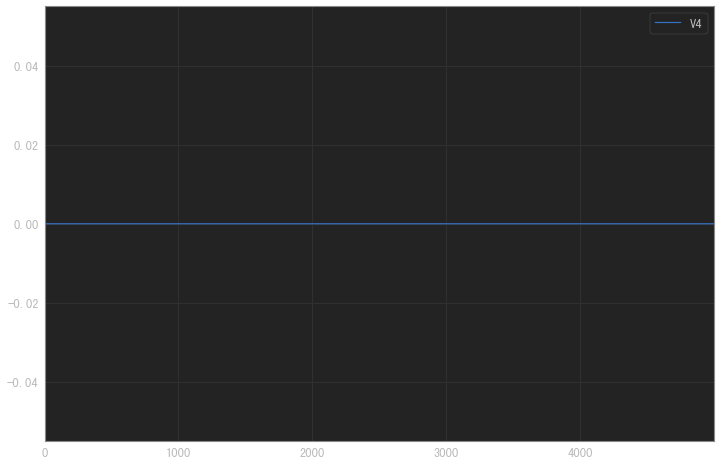

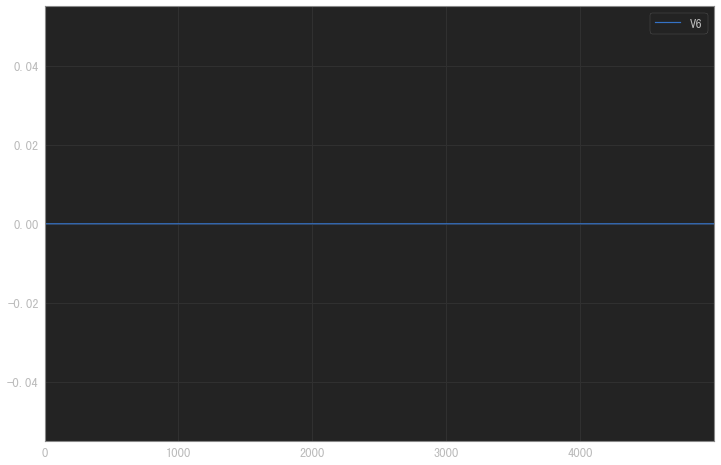

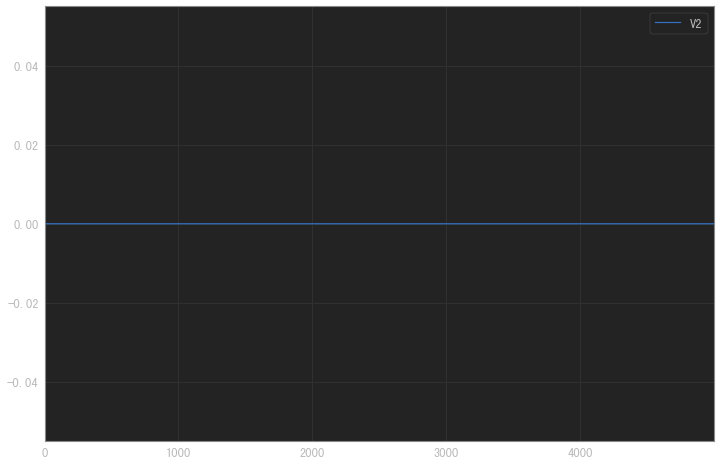

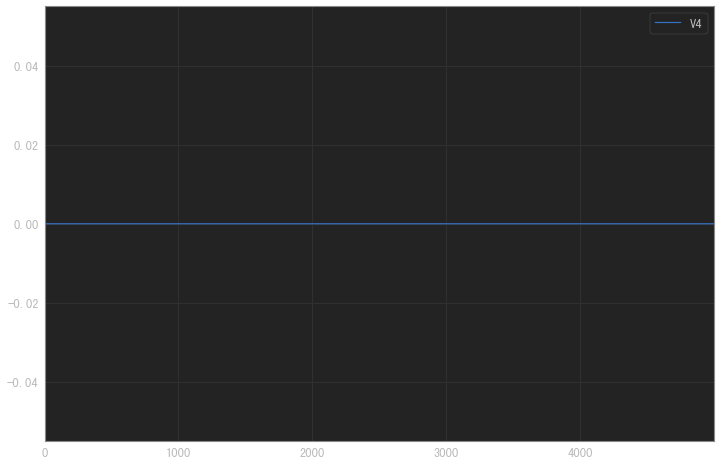

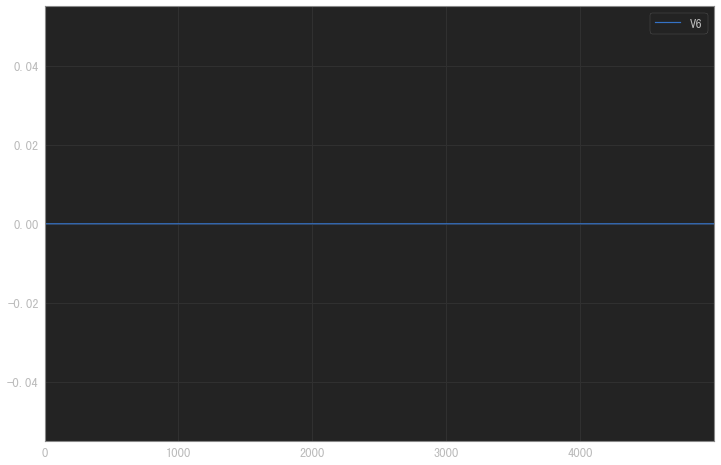

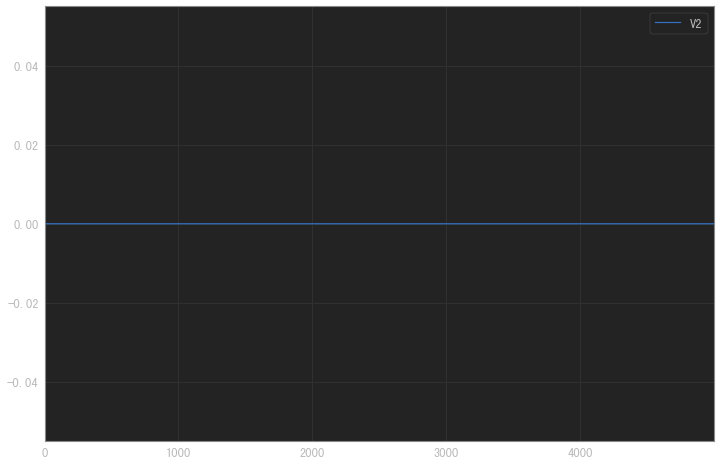

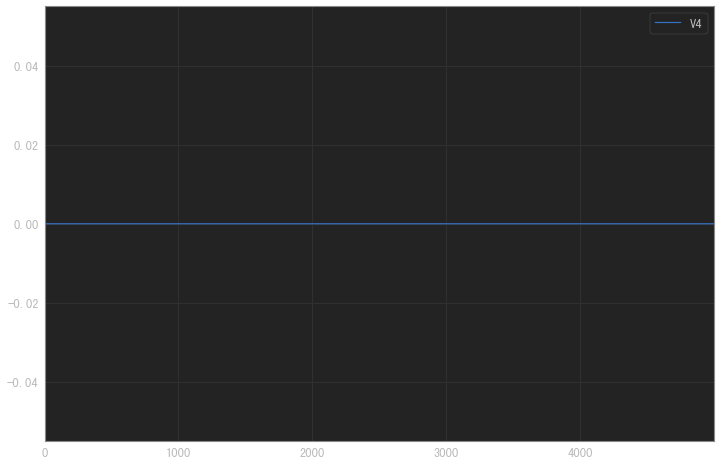

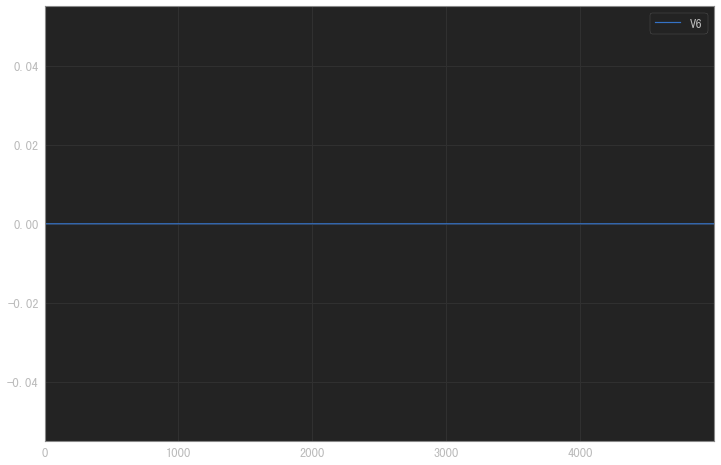

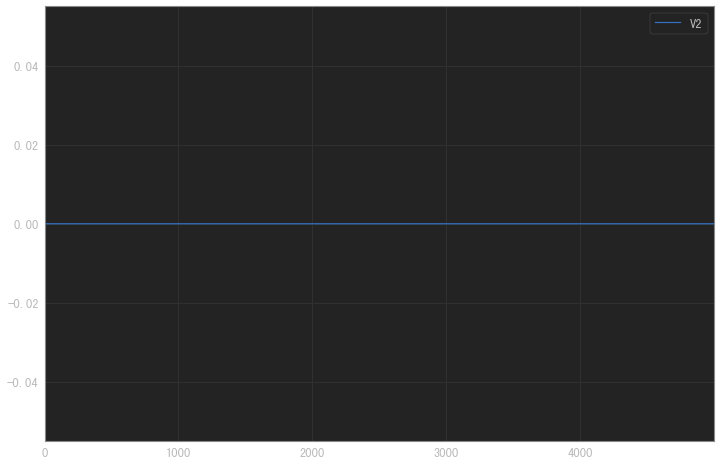

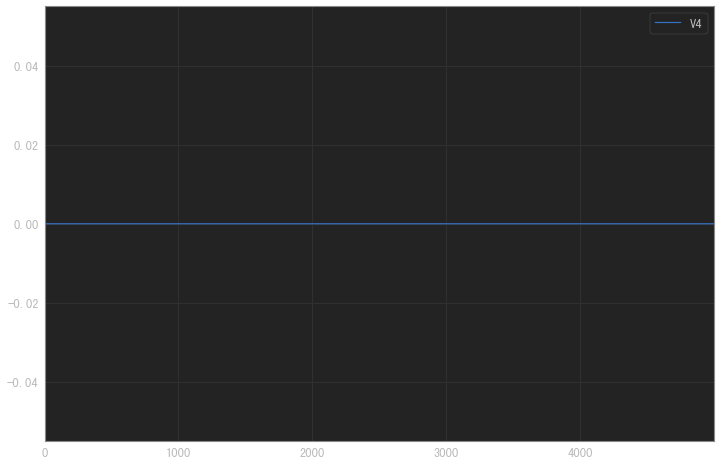

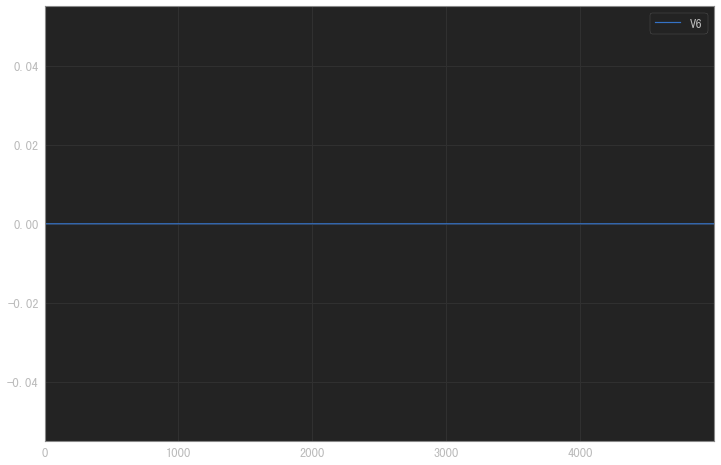

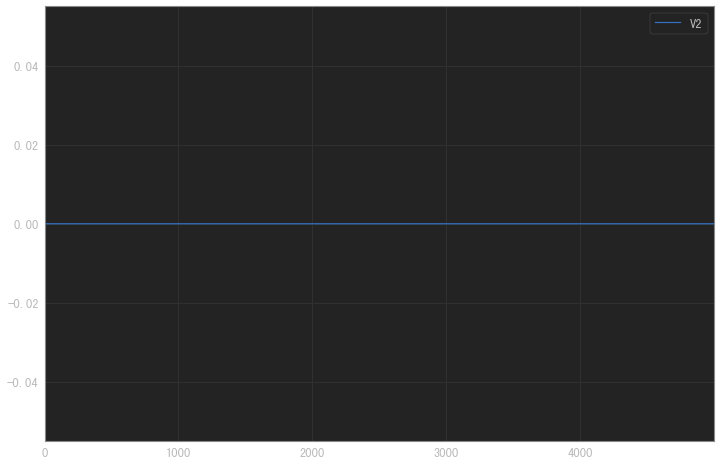

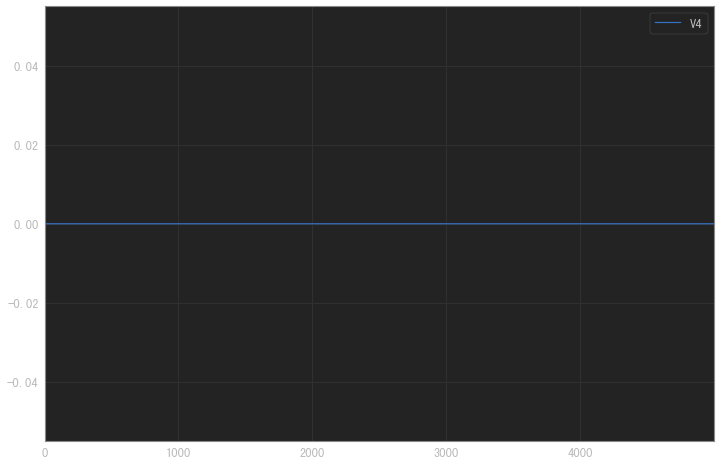

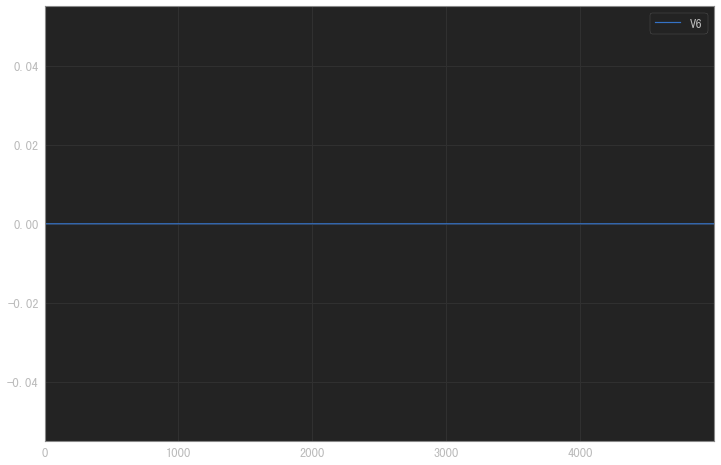

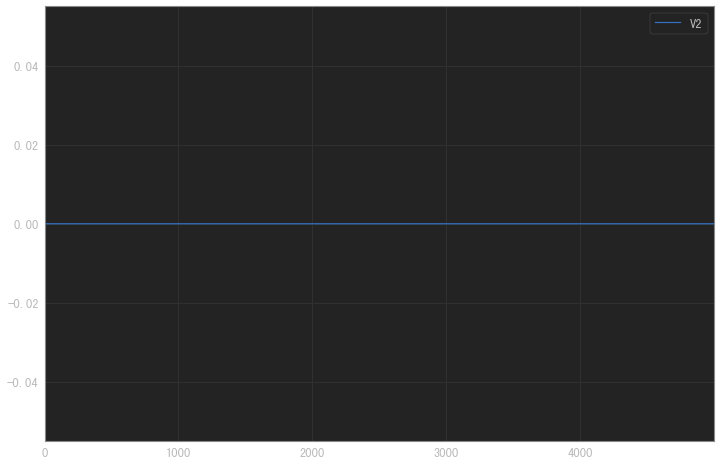

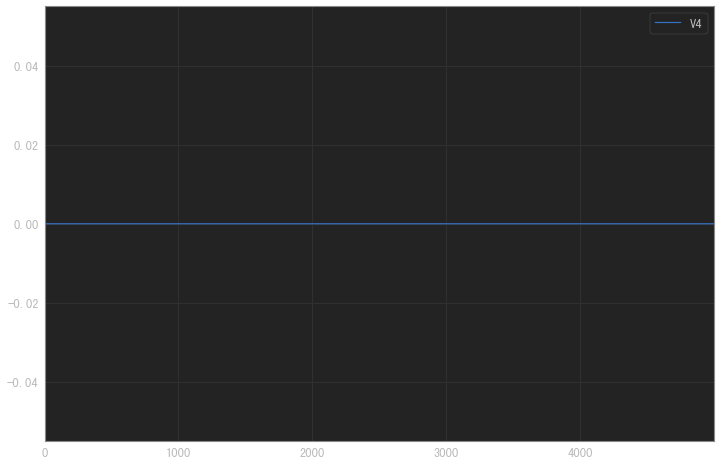

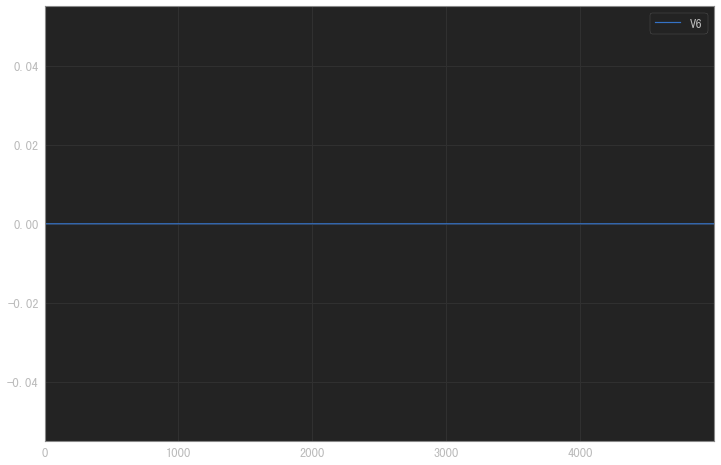

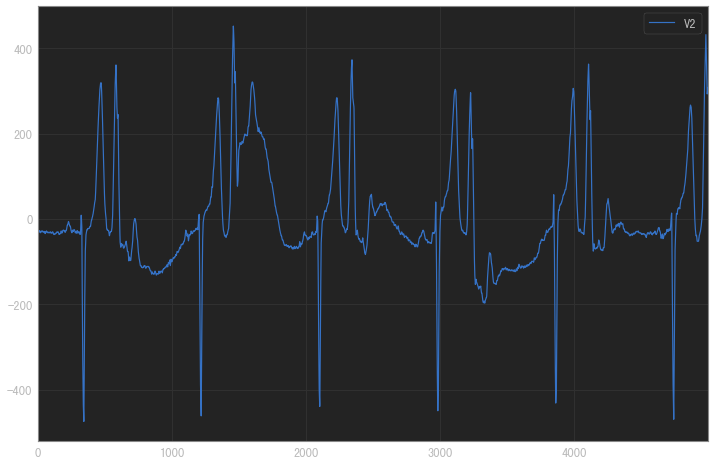

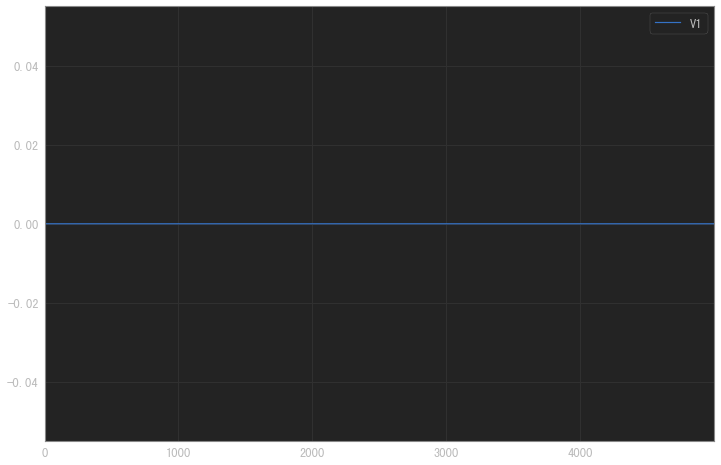

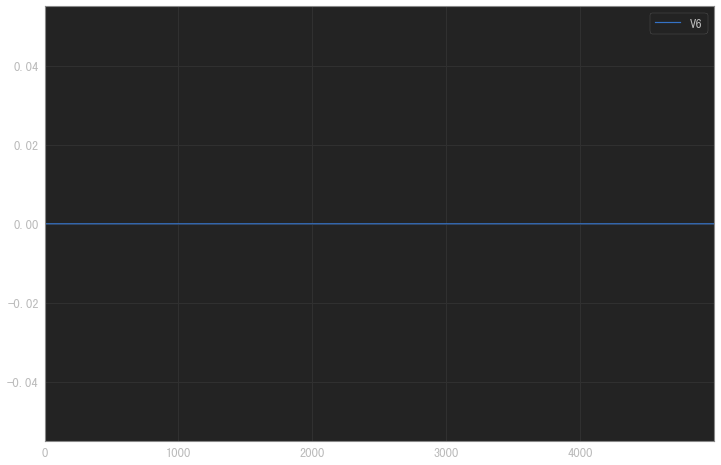

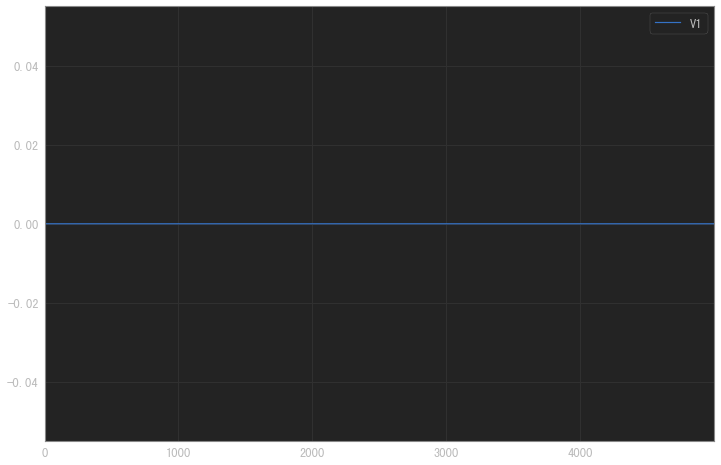

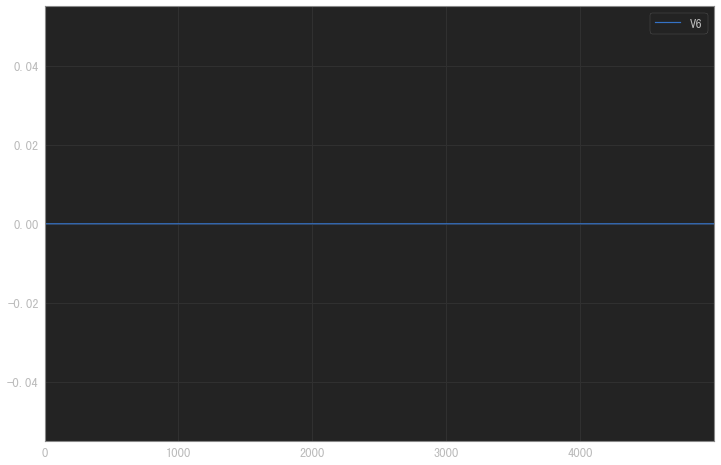

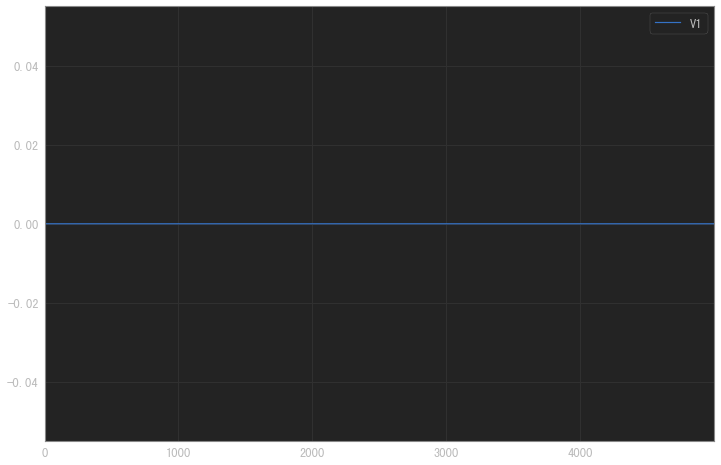

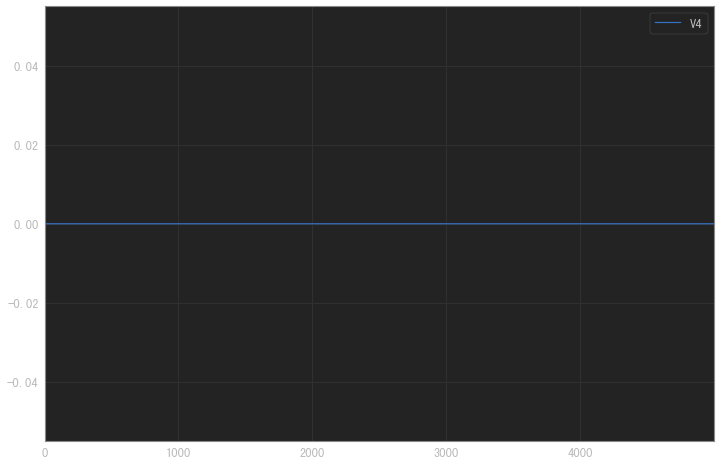

<Figure size 864x576 with 0 Axes>

In [13]:
root = '/home/left/code/python/left5/ecg/ecg_pytorch/data/hf_round1_train/train'
for f, cols in error_dict.items():
    print('mv %s ..' % f)
    df = pd.read_csv(os.path.join(root, f), sep=' ')
    for col in cols:
        df[col].plot()
        plt.legend()
        plt.figure()